# Import and define functions

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import scipy.io as sio
import os
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import glob
import re

In [4]:
from scipy import stats

def calc_quantile(x, q):
    return x.quantile(q)

In [5]:
'''
Below set the analysis type as one of the following options:

-main: primary results for developmental functional connectivity analysis (HBN, ABCD, HCPD, PNC)
-dev_sc: results using developmental structural connectivity (HBN, HCPD, QTAB)
-adult_fc: results using adult functional connectivity (CHCP, HCP)
-adult_sc: results using adult structural connectivity (CHCP, HCP)
-data_amount_train: results varying the scan length of the training data
-data_amount_test: results varying the scan length of the external/test data

In addition, if the analysis type is set to "main," you can optionally change eval_metric to "mae"
'''

# set analysis type
analysis_type = 'main' 

# set evaluation metric (use mae only for main analysis)
eval_metric = 'r'  # 'r', 'mae'

# below set all load and save paths based on the analysis type
if eval_metric=='r' and analysis_type=='main':
    load_path = './processed_csv_files/main'
elif eval_metric=='mae' and analysis_type=='main':
    load_path = './processed_csv_files/main'
    
    df_tmp = pd.read_csv(os.path.join(load_path, 'range_dict.csv'))
    range_dict = dict(zip(df_tmp['pheno'], df_tmp['range']))

elif eval_metric=='r' and analysis_type=='dev_sc':
    load_path = './processed_csv_files/dev_sc'
elif eval_metric=='r' and analysis_type=='adult_fc':
    load_path = './processed_csv_files/adult_fc'
elif eval_metric=='r' and analysis_type=='adult_sc':
    load_path = './processed_csv_files/adult_sc'
elif eval_metric=='r' and analysis_type=='data_amount_train':
    load_path = './processed_csv_files/data_amount_train'
elif eval_metric=='r' and analysis_type=='data_amount_test':
    load_path = './processed_csv_files/data_amount_test'
else:
    print('Error, change options')

In [6]:
# Dictionary for size of held-out data
heldout_size_dict = dict({'abcd':1600, 'hbn':200, 'pnc':200, 'hcpd':100,
                         'hbn_sc':500, 'hcpd_sc':100, 'qtab_sc':100,
                         'hcp':200, 'hcp_sc':200, 'chcp':75, 'chcp_sc':75,
                         'abcd_1_scans':800, 'abcd_2_scans':800, 'abcd_3_scans':800, 'abcd_4_scans':800})

# Dictionary to replace phenotype name abbreviations with full name for plots
pheno_name_dict = dict({'age':'Age','mr':'Matrix reasoning', 'bmi':'BMI' + '$_Z$',
                       'wm':'Working memory', 'ad':'Anxiety/depression', 'ap':'Attention problems',
                       'shape':'Shape Acc', 'rel':'Rel Block Acc','match':'Match Acc'})

In [7]:
# Define several functions
def r_to_p(r, n):
    '''
    for one-sided positive test only
    '''
    t = r / np.sqrt((1-r**2)/ (n-2) )
    p = stats.t.sf(t, df=n-2)   # positive only
    
    return p

def p_to_r(p, n):
    '''
    for one-sided positive test only, undoes r_to_p
    '''
    t_inv = stats.t.isf(p, df=n-2)
    r = np.sqrt(t_inv**2 / ( (n-2) * (1+t_inv**2/(n-2)) ))
    return r 

# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.025)
def qupper(x):
    return x.quantile(0.975)


from scipy.stats import norm
def power_curve_1t(r, N):
    '''
    power curve for correlation (one-tailed, testing >0)
    '''
    # MATLAB code: power1 = 1 - cdf('Normal',1.96,atanh(r_true)*sqrt(N-3), 1);  % one tail
    N = np.array(N)  # allows for multiple N
    return 1-norm.cdf(x=1.645, loc=np.arctanh(r)*np.sqrt(N-3), scale=1)

In [8]:
'''
Set possible sample sizes
'''
if analysis_type!='data_amount_train':
    df_pheno_sample_size = pd.read_csv('./processed_csv_files/main/pheno_dataset_sample_size.csv')
else:  # used different sample sizes for scan length analysis
    df_pheno_sample_size = pd.read_csv('./processed_csv_files/data_amount_train/data_amount_pheno_dataset_sample_size.csv')

# get possible points based on analysis type
if analysis_type!='data_amount_train' and analysis_type!='data_amount_test':    
    num_points = 25
    all_possible_n = np.round(np.logspace(np.log10(20), np.log10(df_pheno_sample_size.n_train.max()), num_points))
    all_possible_n = [int(p) for p in all_possible_n]
elif analysis_type=='data_amount_train':
    num_points = 25
    all_possible_n = np.round(np.logspace(np.log10(20), np.log10(df_pheno_sample_size.n_train.max()), num_points))
    all_possible_n = [int(p) for p in all_possible_n]
elif analysis_type=='data_amount_test':
    num_points = 25
    all_possible_n = np.round(np.logspace(np.log10(20), np.log10(df_pheno_sample_size.n_train.max()), num_points))
    all_possible_n = [int(p) for p in all_possible_n]    

# Within-dataset plots

In [9]:
# load within-dataset processed .csv files
df_within_grouped = pd.read_csv( os.path.join(load_path, 'within_grouped.csv') )
possible_n = df_within_grouped.num_train.unique()

# add this because training/test sizes don't exactly match in scan length data, need to account for this in future plots
if analysis_type=='data_amount_train' or analysis_type=='data_amount_test':
    df_tmp = pd.read_csv('./processed_csv_files/main/within_grouped.csv')
    possible_n = df_tmp.num_train.unique()
    del df_tmp


# for MAE, normalize metric range
if eval_metric=='mae':
    keys_to_normalize = ['mae_med', 'mae_lower', 'mae_upper']#  [k for k in df_performance_grouped.keys() if ('mae' in k and '_sig_' not in k)]
    for k in keys_to_normalize:
        df_within_grouped[k] = df_within_grouped.apply(lambda x: x[k]/range_dict[x.pheno], axis=1)
    

df_within_grouped.head()

train_dataset pheno  num_train     r_med   r_lower   r_upper   mae_med  \
0          abcd   age         20  0.025975 -0.068598  0.095339  6.669563   
1          abcd   age         25  0.032897 -0.071040  0.108100  6.635022   
2          abcd   age         32  0.035703 -0.070038  0.102717  6.685597   
3          abcd   age         41  0.041471 -0.058520  0.116377  6.687100   
4          abcd   age         52  0.035131 -0.057456  0.119284  6.700759   

   mae_lower  mae_upper  p_mae_gt  
0   6.444375   7.135935     0.002  
1   6.410552   7.061573     0.002  
2   6.415311   7.110534     0.002  
3   6.432693   7.025118     0.002  
4   6.438346   7.149137     0.002

In [10]:
'''
Get within-dataset ground truth 
'''
if analysis_type=='main' and eval_metric=='r':
    df_within_grouped_gt = pd.read_csv( os.path.join(load_path, 'within_grouped.csv') )
    df_within_grouped_gt['heldout_size'] = df_within_grouped_gt['train_dataset'].apply(lambda x: heldout_size_dict[x])
    df_tmp = df_within_grouped_gt.groupby(['train_dataset', 'pheno'], as_index=False).agg(num_train_max=('num_train', 'max'))
    df_within_grouped_gt = df_within_grouped_gt.merge(df_tmp, on=['train_dataset', 'pheno'])
    df_within_grouped_gt = df_within_grouped_gt[df_within_grouped_gt.num_train==df_within_grouped_gt.num_train_max].reset_index(drop=True)
    df_within_grouped_gt['p_gt'] = df_within_grouped_gt.apply(lambda x: r_to_p(x.r_med, x.heldout_size), axis=1)
    df_within_grouped_gt.to_csv(os.path.join(load_path, 'within_gt.csv'), index=False)
    df_within_grouped_gt

/home/mjr239/anaconda3/envs/repro/lib/python3.9/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


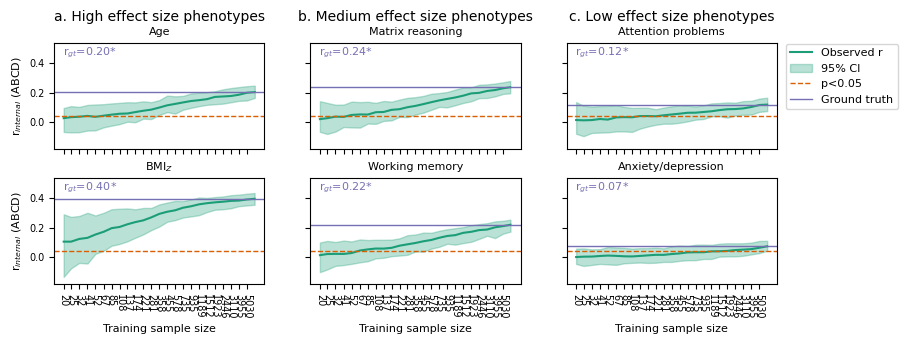

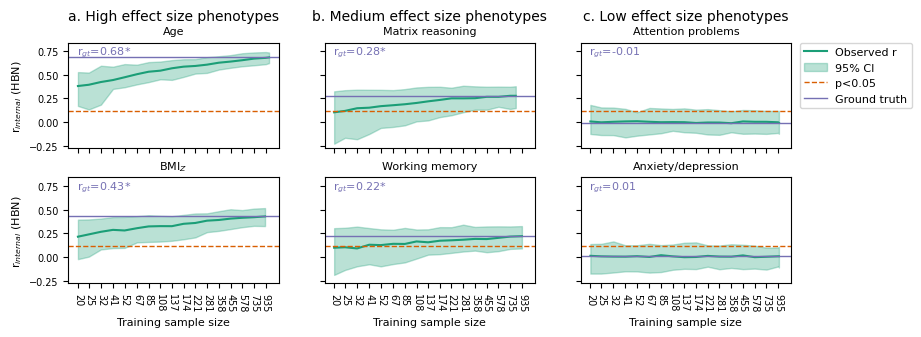

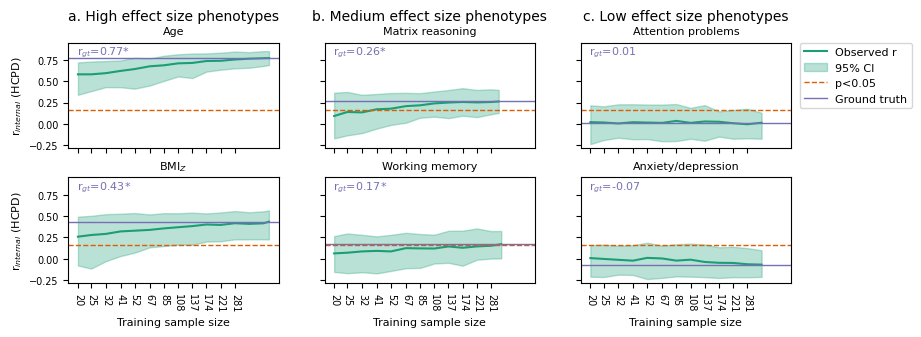

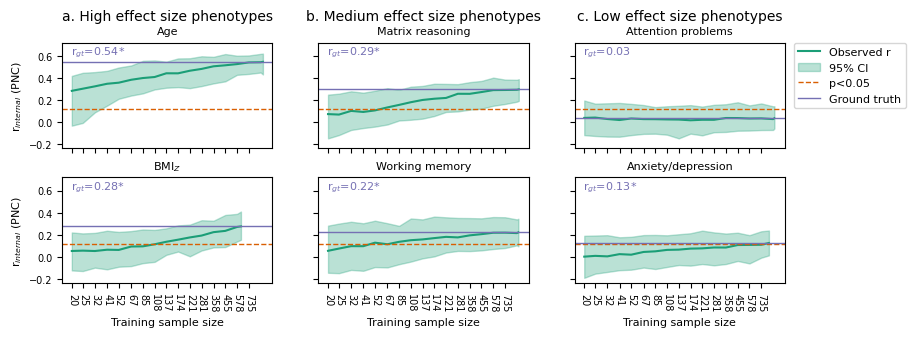

In [11]:
'''
Main figure for within-dataset performance in HBN
'''

# set plot parameters by analysis type
if analysis_type=='main':
    all_datasets = ['abcd', 'hbn', 'hcpd', 'pnc'] 
    pheno_all = ['age', 'mr', 'ap', 'bmi', 'wm', 'ad']
    plot_rows = 2
    figsize=(8, 3)
elif analysis_type=='dev_sc':
    pheno_all = ['age', 'wm', 'ad']
    all_datasets = ['hbn_sc', 'hcpd_sc', 'qtab_sc']
    plot_rows = 1
    figsize=(8, 1.5)
elif analysis_type=='adult_fc':
    pheno_all = ['age', 'rel', 'shape']
    all_datasets = ['chcp', 'hcp']
    plot_rows = 1
    figsize=(8, 1.5)   
elif analysis_type=='adult_sc':
    pheno_all = ['age', 'rel', 'match']
    all_datasets = ['chcp_sc', 'hcp_sc']
    plot_rows = 1
    figsize=(8, 1.5) 
elif analysis_type=='data_amount_train':
    all_datasets = ['abcd_1_scans', 'abcd_2_scans', 'abcd_3_scans', 'abcd_4_scans'] 
    pheno_all = ['age', 'mr', 'ap', 'bmi', 'wm', 'ad']
    plot_rows = 2
    figsize=(8, 3)
elif analysis_type=='data_amount_test':
    print('Error not available')
    print(error)

# loop over all datasets
for dataset in all_datasets:
    
    # initialize count
    total_loop_count = 0    
    
    # get number of phenotypes per row
    pheno_per_row = int(len(pheno_all)/plot_rows)
    
    # make subplots
    fig, axs = plt.subplots(nrows=plot_rows,
                            ncols=pheno_per_row,
                            figsize=figsize, sharey=True, sharex=True)
    plt.tight_layout()

    if plot_rows==1:
        axs = axs[None, :]
    
    # Set axis limits for all subplots
    if (eval_metric=='r') and ('adult' not in analysis_type):
        yax_lim = [ df_within_grouped[(df_within_grouped.train_dataset==dataset)][eval_metric+'_lower'].min()-0.05,
                   df_within_grouped[(df_within_grouped.train_dataset==dataset)][eval_metric+'_upper'].max()+0.1]
    elif (eval_metric=='r') and ('adult' in analysis_type):
        yax_lim = [ df_within_grouped[(df_within_grouped.train_dataset==dataset)][eval_metric+'_lower'].min()-0.05,
                   df_within_grouped[(df_within_grouped.train_dataset==dataset)][eval_metric+'_upper'].max()+0.2]
    elif eval_metric=='mae':
        offset_lim = df_within_grouped[(df_within_grouped.train_dataset==dataset)][eval_metric+'_upper'].max()*0.12
        yax_lim = [ df_within_grouped[(df_within_grouped.train_dataset==dataset)][eval_metric+'_lower'].min()-offset_lim,
                   df_within_grouped[(df_within_grouped.train_dataset==dataset)][eval_metric+'_upper'].max()+offset_lim]

    plt.setp(axs, ylim=yax_lim)
                                  
    # loop over phenotypes
    for pheno_idx, pheno in enumerate(pheno_all):
               
        # update plot column indices
        plot_col_idx = total_loop_count%pheno_per_row
        # update plot row indices
        if plot_col_idx==0:
            plot_row_idx = int( np.floor(total_loop_count/pheno_per_row) )
        
        # get dataframe to plot
        df_plot = df_within_grouped[(df_within_grouped.train_dataset==dataset) &
                                   (df_within_grouped.pheno==pheno)].reset_index(drop=True)
        # all possible sample sizes
        possible_n_tmp = [int(p) for p in df_plot.num_train.unique() if p in all_possible_n]
        
        if len(df_plot)>0:
            
            # color blind friendly palette obtained from colorbrewer:
            # https://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=3
            
            # plot and fill
            axs[plot_row_idx, plot_col_idx ].plot(df_plot.num_train, df_plot[eval_metric+'_med'],
                                                  color='#1b9e77', label='Observed r')
            axs[plot_row_idx, plot_col_idx].fill_between(df_plot.num_train,
                                                     df_plot[eval_metric+'_lower'],
                                                         df_plot[eval_metric+'_upper'],
                                                    alpha=.3, color='#1b9e77',
                                                        label='95% CI')
            
            
            # add in horizontal lines for significance
            if eval_metric=='r':
                axs[plot_row_idx, plot_col_idx].axhline(y=p_to_r(0.05, heldout_size_dict[dataset]),
                                                        xmin=0, xmax=1000,
                                                        color='#d95f02', linestyle='--', lw=1,
                                                       label='p<0.05')
            
            # add in horizontal line for ground truth
            eval_metric_gt = float(df_plot[df_plot.num_train==(df_plot.num_train.max())][eval_metric+'_med'])  # get ground truth at max sample size
            if eval_metric == 'r':
                is_sig = (eval_metric_gt > p_to_r(0.05, heldout_size_dict[dataset]) )  # determine if significant
            elif eval_metric =='mae':
                p_mae_gt = float(df_plot[df_plot.num_train==(df_plot.num_train.max())]['p_mae_gt'])  # get ground truth p val at max sample size
                is_sig = 1*(p_mae_gt<.05)  # determine if significant
                
            if is_sig:  # add * to text if significant
                sig_str = '*'
            else:
                sig_str = ''
                
            # plot ground truth line
            axs[plot_row_idx, plot_col_idx].axhline(y=eval_metric_gt, color='#7570b3', lw=1,
                                                       label='Ground truth')
            # label with ground truth
            if eval_metric=='r':
                gt_text_y_loc = 0.98
            elif eval_metric=='mae':
                gt_text_y_loc = 0.12
            axs[plot_row_idx, plot_col_idx].text(0.04, gt_text_y_loc,
                                                 eval_metric+'$_{gt}$' +  '={:.2f}{:s}'.format(eval_metric_gt, sig_str),
                                                 color='#7570b3', ha='left', va='top', fontsize=8,
                                                 transform=axs[plot_row_idx, plot_col_idx].transAxes )
                                                # transform=axs[plot_row_idx, plot_col_idx].get_yaxis_transform()



        else:  # if no data available
            axs[plot_row_idx, plot_col_idx].set_xticks([])
            axs[plot_row_idx, plot_col_idx].text(0.9, 0.5, 'N/A', transform=axs[plot_row_idx, plot_col_idx].transAxes,
                                            verticalalignment='center', horizontalalignment='center')
            
    
        # replace phenotype with full name
        pheno = pheno_name_dict[pheno]
        
        # title
        axs[plot_row_idx, plot_col_idx].set_title(pheno, fontsize=8)
        if plot_col_idx==0:
            axs[plot_row_idx, plot_col_idx].set_ylabel(eval_metric+'$_{internal}$' +  ' ({:s})'.format(dataset.upper().replace('_', '-')),
                                                       fontsize=8)
        if (plot_row_idx+1)==plot_rows:
            axs[plot_row_idx, plot_col_idx].set_xlabel('Training sample size', fontsize=8)

        # tick parameters and settings
        axs[plot_row_idx, plot_col_idx].set_xscale('log')
        axs[plot_row_idx, plot_col_idx].xaxis.set_major_formatter(ScalarFormatter())
        axs[plot_row_idx, plot_col_idx].set_xticks(possible_n_tmp)
        axs[plot_row_idx, plot_col_idx].tick_params(axis='both', which='major', labelsize=7)
        for tick in axs[plot_row_idx, plot_col_idx].get_xticklabels():
            tick.set_rotation(-90)
        # remove minor xticks (extra ticks)
        axs[plot_row_idx, plot_col_idx].set_xticks([], minor=True)
        
        # iterate loop count to keep track of where to plot
        total_loop_count+=1
        
        # legend for last subplot
        if total_loop_count == (plot_rows*pheno_per_row):
            handles, labels = axs[plot_row_idx, plot_col_idx].get_legend_handles_labels()
            fig.legend(handles, labels, bbox_to_anchor=(1.12, 0.95), fontsize=8)    
            
    # add effect size group titles
    effect_size_groups = ['a. High effect size phenotypes','b. Medium effect size phenotypes','c. Low effect size phenotypes']
     # want d, e, f for certain figure
    if analysis_type=='data_amount_train' and dataset=='abcd_4_scans':
        effect_size_groups = [e.replace('a. ', 'd. ').replace('b. ', 'e. ').replace('c. ', 'f. ') for e in effect_size_groups]
    if 'adult' not in analysis_type:
        
        for i in range(0, axs.shape[-1]):
            pos1 = axs[0, i].get_position()   
            new_pos = 0.5*(pos1.x0 + pos1.x1 )  
            fig.text(new_pos, 1.02, effect_size_groups[i], ha='center', va='center', fontsize=10)

#     fig.savefig(os.path.join(fig_path, 'within','within_pred_' + dataset + '.png'), 
#                 dpi=400, bbox_inches='tight')

# Performance plots

In [12]:
# load power results
df_performance_grouped = pd.read_csv(os.path.join(load_path, 'performance_grouped.csv') )

# for MAE, normalize metric range
if eval_metric=='mae':
    keys_to_normalize = ['mae_med', 'mae_lower', 'mae_upper', 'mae_gt', 'mae_ground_truth']#  [k for k in df_performance_grouped.keys() if ('mae' in k and '_sig_' not in k)]
    for k in keys_to_normalize:
        df_performance_grouped[k] = df_performance_grouped.apply(lambda x: x[k]/range_dict[x.pheno], axis=1)
    
df_performance_grouped.head()

train_dataset test_dataset pheno  num_train  num_test     r_med   r_lower  \
0          abcd          hbn   age         20        20  0.067586 -0.479925   
1          abcd          hbn   age         20        25  0.069601 -0.441084   
2          abcd          hbn   age         20        32  0.072322 -0.411359   
3          abcd          hbn   age         20        41  0.072463 -0.387386   
4          abcd          hbn   age         20        52  0.072057 -0.366058   

    r_upper    mae_med  mae_lower  mae_upper     r_gt     mae_gt  r_pos_rate  \
0  0.557134  34.836675  22.628669  48.505260  0.48106  34.615652      0.1248   
1  0.523272  34.697062  24.093087  46.781774  0.48106  34.615652      0.1496   
2  0.501687  34.718490  25.374151  45.884940  0.48106  34.615652      0.1815   
3  0.476683  35.379287  25.561786  45.493060  0.48106  34.615652      0.2172   
4  0.457242  36.030783  27.687414  42.813757  0.48106  34.615652      0.2479   

   mae_pos_rate  r_sig_ground_truth  mae_sig_ground_truth  r_ground_truth  \
0        0.0820                 1.0                   1.0         0.48106   
1        0.0927                 1.0                   1.0         0.48106   
2        0.1112                 1.0                   1.0         0.48106   
3        0.1351                 1.0                   1.0         0.48106   
4        0.1458                 1.0                   1.0         0.48106   

   mae_ground_truth  
0         34.615652  
1         34.615652  
2         34.615652  
3         34.615652  
4         34.615652

In [13]:
'''
Save ground truth performance
'''
df_gt_tmp = df_performance_grouped.groupby(['train_dataset', 'test_dataset', 'pheno'], 
                              as_index=False).agg(r_gt=('r_gt','min'),
                                                  r_sig_ground_truth=('r_sig_ground_truth','min'),
                                                  num_test_gt=('num_test','max'))
df_gt_tmp['p_gt'] = df_gt_tmp.apply(lambda x: r_to_p(x.r_gt, x.num_test_gt), axis=1)
df_gt_tmp.to_csv(os.path.join(load_path,'ground_truth_'+analysis_type+'.csv'),
                 index=False)
del df_gt_tmp

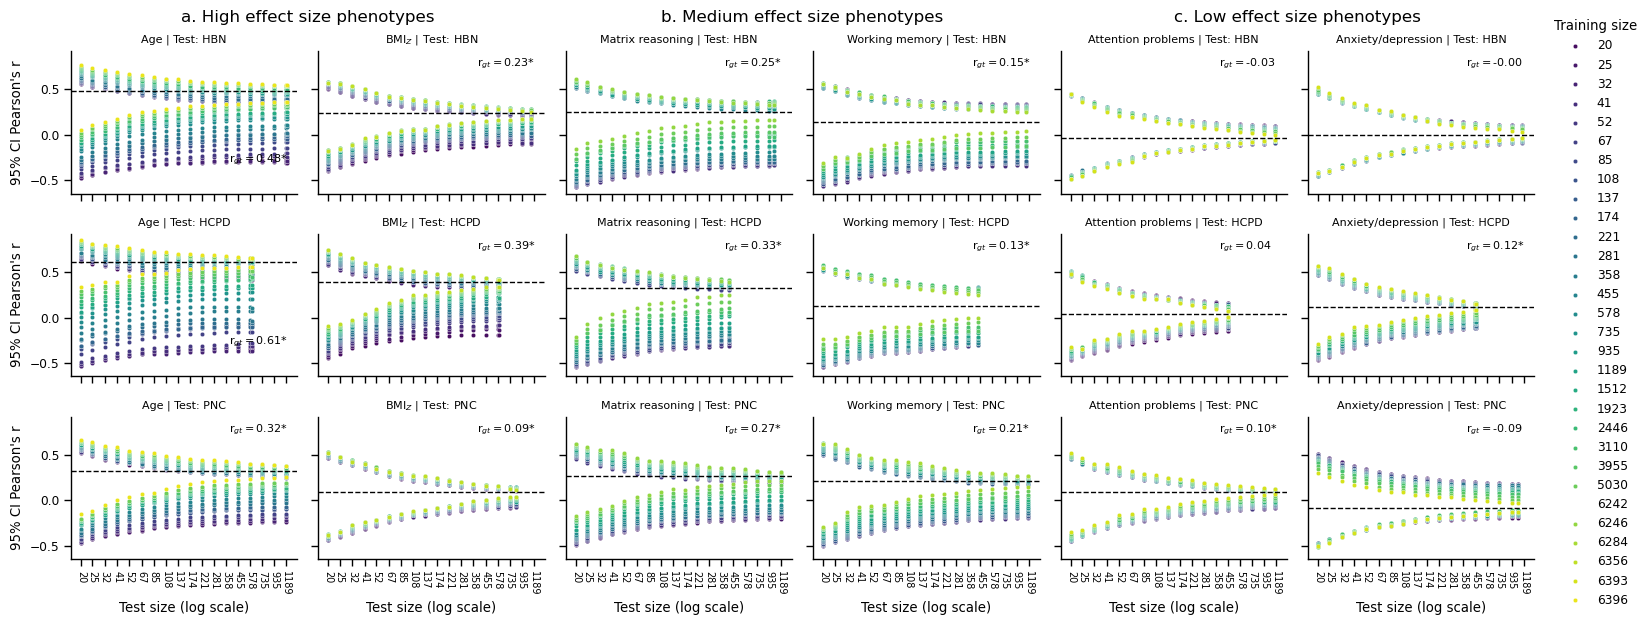

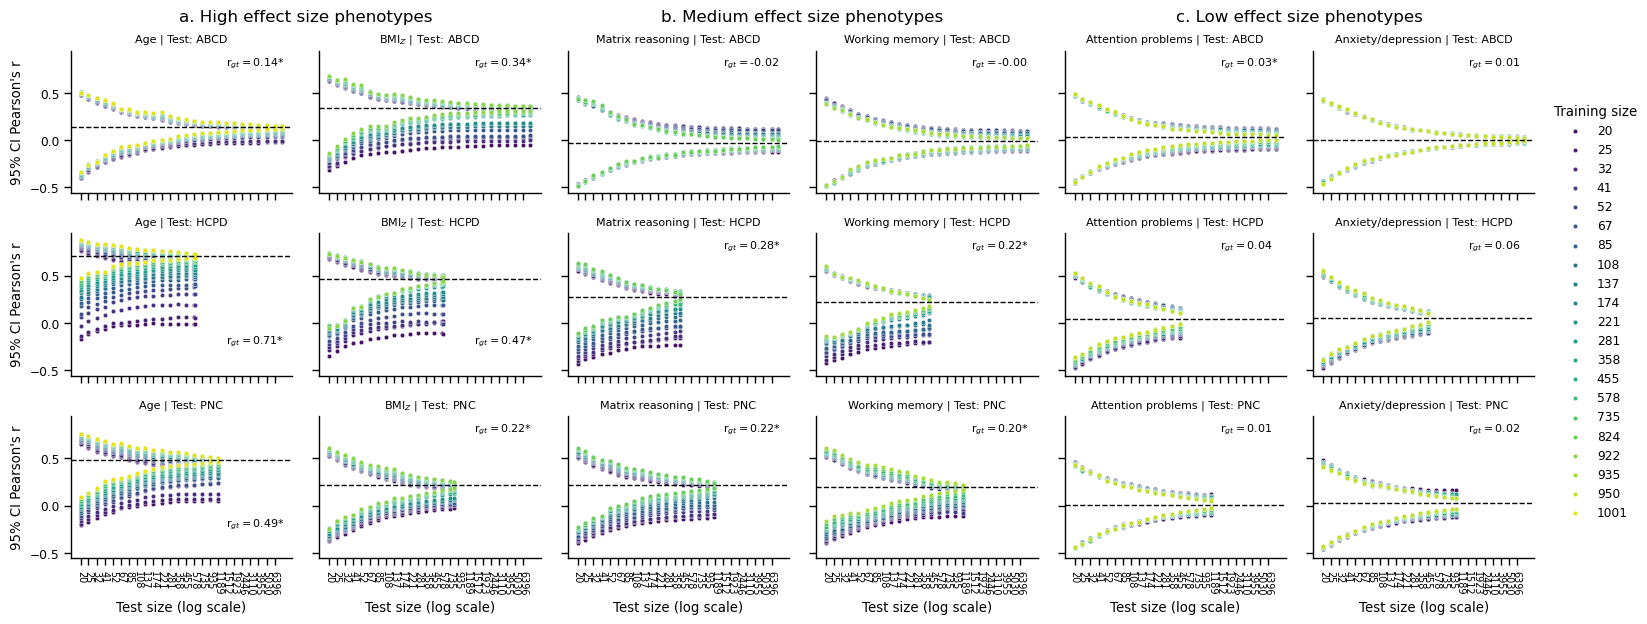

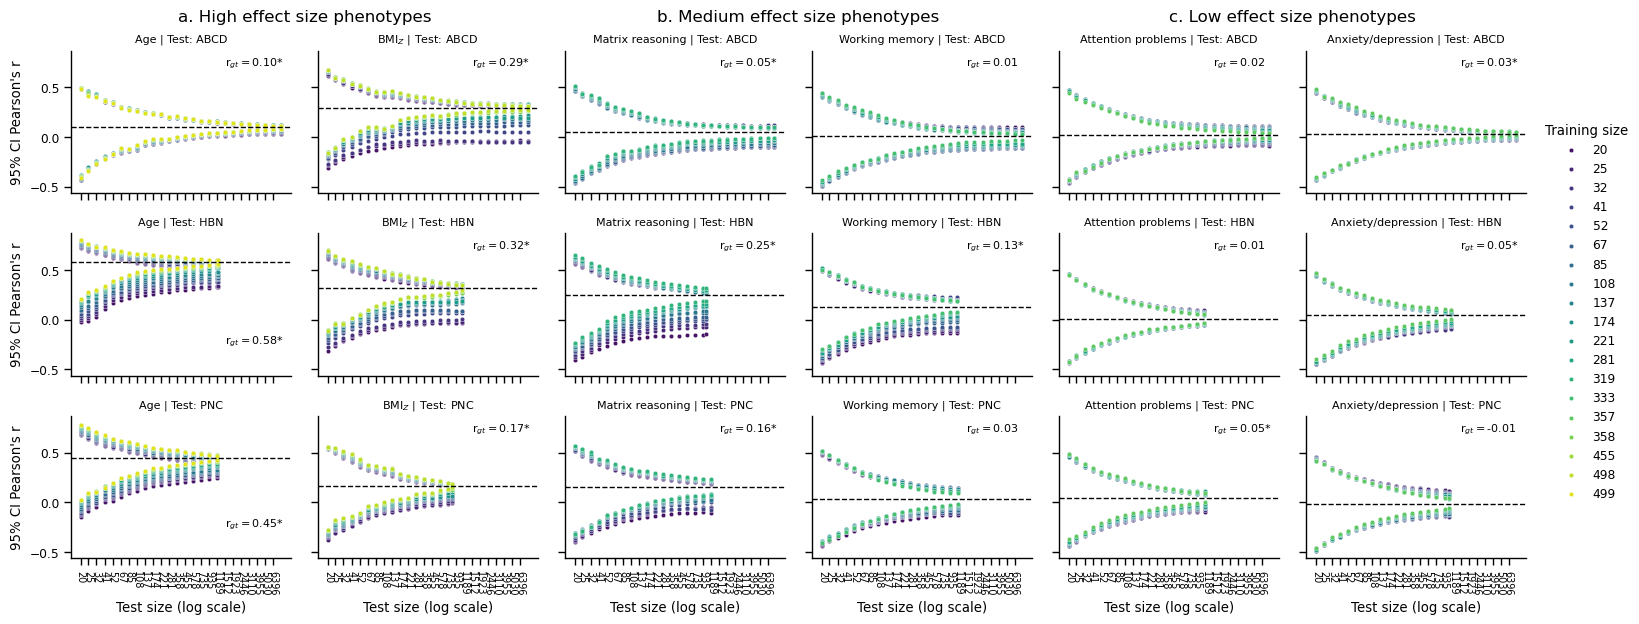

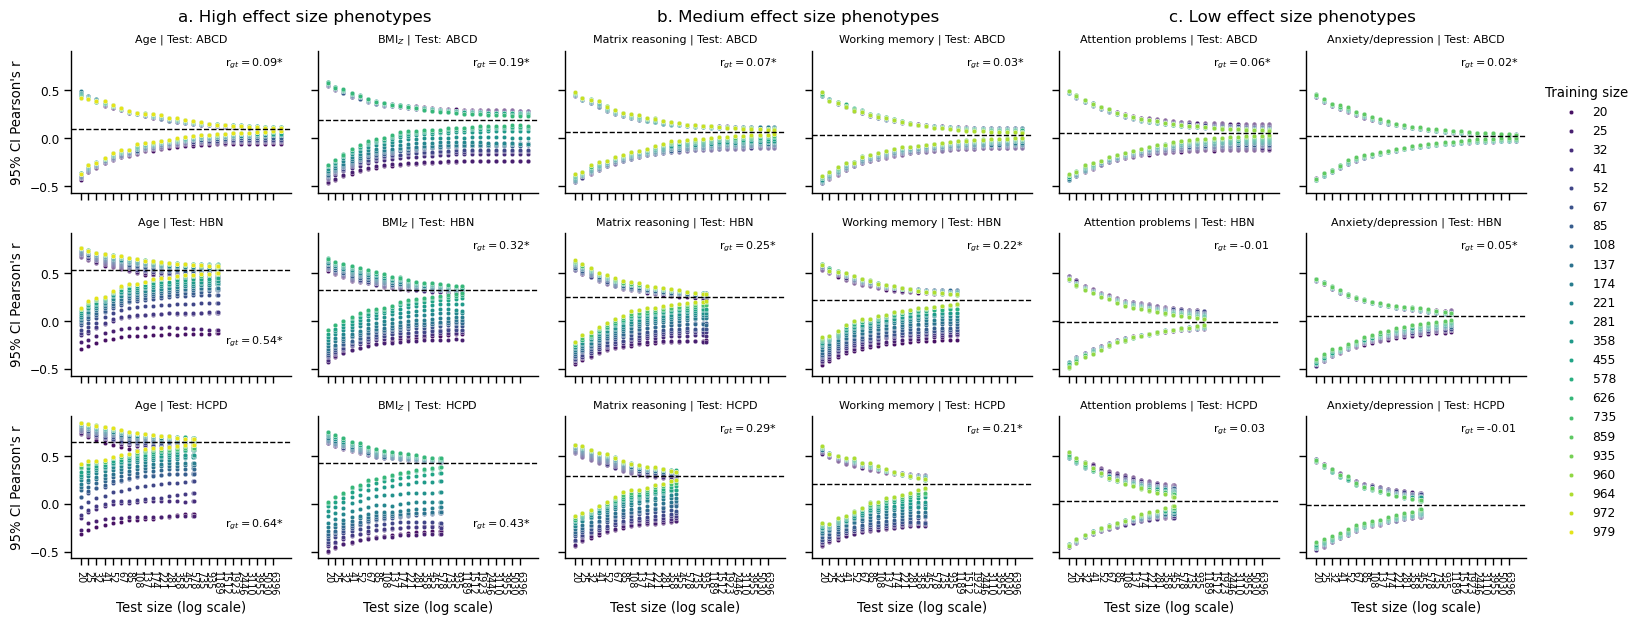

In [14]:
'''
Set the metric_type to "med" to plot median results
Set it to "ci" to plot confidence intervals
'''

sns.set_context('paper')

# plot type of metric
metric_type = 'ci'  # 'med', 'ci'


# set plot parameters based on analysis type
if analysis_type=='main':
    height = 2
    aspect = 1.3
    col_order=['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    all_datasets = ['abcd', 'hbn', 'hcpd', 'pnc']

elif analysis_type=='dev_sc':
    col_order = ['age', 'wm', 'ad']
    all_datasets = ['hbn_sc', 'hcpd_sc', 'qtab_sc']
    height = 2.2
    aspect = 1.3
elif analysis_type=='adult_fc':
    col_order = ['age', 'rel', 'shape']
    all_datasets = ['chcp', 'hcp']
    height = 2.2
    aspect = 1.3
elif analysis_type=='adult_sc':
    col_order = ['age', 'rel', 'match']
    all_datasets = ['chcp_sc', 'hcp_sc']
    height = 2.2
    aspect = 1.3    
elif analysis_type=='data_amount_train':
    col_order = ['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    all_datasets = ['abcd_1_scans', 'abcd_2_scans', 'abcd_3_scans', 'abcd_4_scans']
    height = 2.2
    aspect = 1.3   
elif analysis_type=='data_amount_test':
    col_order = ['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    all_datasets = ['hbn', 'hcpd', 'pnc']
    height = 2
    aspect = 1.3       
 
title_size = 8
label_size = rcParams['axes.labelsize']
suptitle_size = 10
gt_fontsize = 8

# loop over all training datasets
for train_dataset in all_datasets:
    
    # get only training dataset of interest
    df_plot = df_performance_grouped[(df_performance_grouped.train_dataset==train_dataset)].reset_index(drop=True)
    if analysis_type!='data_amount_train' and analysis_type!='data_amount_test':
        row_order = [d for d in all_datasets if d!=train_dataset]
    elif analysis_type=='data_amount_train':
        row_order = ['hbn', 'hcpd', 'pnc']
    elif analysis_type=='data_amount_test':
        row_order = ['abcd_1_scans', 'abcd_2_scans', 'abcd_3_scans', 'abcd_4_scans']
    rowvar = 'test_dataset'

    # make extended df for confidence intervals
    if metric_type=='ci':   
        len_original = len(df_plot)
        df_plot = pd.concat([df_plot, df_plot])  
        
        # make first half of dataframe lower bound CI, second half upper bound CI
        df_plot[eval_metric+'_ci'] =  list(df_plot[eval_metric+'_lower'])[:len_original] +\
                                        list(df_plot[eval_metric+'_upper'])[:len_original]
        df_plot[eval_metric+'_ci_type'] = len_original*['2.5%'] + len_original*['97.5%']

    # make facet grid
    g = sns.FacetGrid(df_plot, col="pheno",  row=rowvar, hue='num_train',
                     row_order=row_order, col_order=col_order,
                     palette=sns.color_palette("viridis", len(df_plot.num_train.unique())),
                     height=height, aspect=aspect)
    g.map(sns.scatterplot, "num_test", eval_metric+"_" + metric_type, s=10).set(xscale = 'log')
    g.set_xlabels('Test size (log scale)', fontsize=label_size)
    g.add_legend(title='Training size')

    # adjust y limits
    if eval_metric=='mae':
        g.set(ylim=[-0.04, 0.75])
   
    elif 'adult' in analysis_type:        
        # extra axis space for adult datasets
        g.set(ylim=[ float(df_plot[eval_metric+'_ci'].min()-0.2),
                    float(df_plot[eval_metric+'_ci'].max())+0.2 ])
        
        # Legend title
        g.legend.get_title().set_fontsize(8)
        # Legend texts
        for text in g.legend.texts:
            text.set_fontsize(7)

    # iterate over axes of FacetGrid
    for i, ax in enumerate(g.axes.flat):
        ax.set_xticks([], minor=True)  # remove minor xticks
        ax.set_xticks([s for s in df_plot.num_test.unique() if s in possible_n])
        ax.xaxis.set_major_formatter(ScalarFormatter())

        for tick in ax.get_xticklabels():
            tick.set_rotation(270)
        ax.tick_params(axis='x', labelsize=7)


        # get datasets and phenotypes names from title
        title_txt = g.axes.flat[i].title.get_text()
        txt_tmp = title_txt.split('|')
        txt_tmp = [tmp.split('=') for tmp in txt_tmp]
        test_dataset_name = txt_tmp[0][-1].strip()
        pheno_name = txt_tmp[1][-1].strip()


        # get ground truth values - depends on how many training datasets
        eval_metric_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                            (df_plot.test_dataset==test_dataset_name), 
                             eval_metric+'_ground_truth'].mean()  # mean should be the same as taking first
        sig_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                    (df_plot.test_dataset==test_dataset_name), 
                     eval_metric+'_sig_ground_truth'].mean()   

        # add star if significant 
        if sig_gt==1:
            sig_gt_str='*'
        else:
            sig_gt_str=''

        # replace phenotype names for plot
        pheno_name = pheno_name_dict[pheno_name]

        # set title
        ax.set_title(pheno_name + ' | Test: ' + test_dataset_name.upper().replace('_SC', '-SC'),
                    fontsize=title_size)

        # horizontal line for ground truth
        ax.axhline(eval_metric_gt, linestyle='--', color='black', lw=1)
        # put ground truth performance on plot
        if metric_type=='ci' and eval_metric=='r':  # change offset of ground truth text annotation based on which plot
            text_offset = 0.14
        elif metric_type=='med' and eval_metric=='r':
            text_offset = 0.02
        elif metric_type=='ci' and eval_metric=='mae':
            text_offset = 0
        elif metric_type=='med' and eval_metric=='mae':
            text_offset = 0

        # add ground truth text
        if (eval_metric=='r') and ('adult' not in analysis_type) and (analysis_type!='data_amount_train'):
            gt_x_text_position = 0.7
            if eval_metric_gt<.4:
                gt_y_text_position = 0.72
            else:
                gt_y_text_position = 0.05
        elif (eval_metric=='mae') and ('adult' not in analysis_type) and (analysis_type!='data_amount_train'):
            gt_x_text_position = 0.7
            gt_y_text_position = 0.6
        elif analysis_type=='data_amount_train':
            gt_x_text_position = 0.7
            gt_y_text_position = 0.72
        elif 'adult' in analysis_type:  # different parameters for adult dataset
            gt_x_text_position = 0.7
            gt_y_text_position = 0.75
        ax.text(gt_x_text_position, gt_y_text_position+text_offset, eval_metric+'$_{gt}=$' + '{:.2f}'.format(eval_metric_gt) + sig_gt_str,
                horizontalalignment='left',
                verticalalignment='bottom',
                transform=ax.transAxes,
               fontsize=gt_fontsize)

        # change axis label based on whether using median, upper, or lower
        if metric_type=='med' and eval_metric=='r':
            ax.set_ylabel("Median Pearson's r", fontsize=label_size)
        elif metric_type=='ci' and eval_metric=='r':
            ax.set_ylabel("95% CI Pearson's r", fontsize=label_size)
        elif metric_type=='med' and eval_metric=='mae':
            ax.set_ylabel("Median MAE", fontsize=label_size)
        elif metric_type=='ci' and eval_metric=='mae':
            ax.set_ylabel("95% CI MAE", fontsize=label_size)

    # add effect size group titles
    effect_size_groups = ['a. High effect size phenotypes','b. Medium effect size phenotypes','c. Low effect size phenotypes']
    title_count = 0
    if analysis_type=='main':  # for main analysis, have 6 pheno
        for i in range(0, g.axes.shape[-1], 2):
            pos1 = g.axes[0, i].get_position()
            pos2 = g.axes[0, i+1].get_position()

            new_pos = 0.25*(pos1.x0 + pos1.x1 + pos2.x0 + pos2.x1)

            g.fig.text(new_pos, 1, effect_size_groups[title_count], ha='center', va='center', fontsize=12)
            title_count+=1   
    elif analysis_type=='dev_sc': 
        for i in range(0, g.axes.shape[-1], 1):
            pos1 = g.axes[0, i].get_position()

            new_pos = 0.5*(pos1.x0 + pos1.x1)                
            
            g.fig.text(new_pos, 1, effect_size_groups[title_count], ha='center', va='center', fontsize=suptitle_size)
            title_count+=1      

#     # save figure
#     g.savefig(os.path.join(fig_path, 'performance/' + metric_type + '_' + train_dataset + '.png'),
#               dpi=400, bbox_inches='tight')

# Power plots


In [15]:
# load power results
df_power_grouped = pd.read_csv(os.path.join(load_path, 'power_grouped.csv') )

# remove scaled phenotypes
df_power_grouped = df_power_grouped[(df_power_grouped.pheno!='mr_scaled') & 
                                   (df_power_grouped.pheno!='wm_corrected')].reset_index(drop=True)

df_power_grouped.head()

train_dataset test_dataset pheno  num_train  num_test  r_pos_rate  \
0          abcd          hbn   age         20        20      0.1248   
1          abcd          hbn   age         20        25      0.1496   
2          abcd          hbn   age         20        32      0.1815   
3          abcd          hbn   age         20        41      0.2172   
4          abcd          hbn   age         20        52      0.2479   

   r_sig_ground_truth  r_ground_truth  mae_pos_rate  mae_sig_ground_truth  \
0                 1.0         0.48106        0.0820                   1.0   
1                 1.0         0.48106        0.0927                   1.0   
2                 1.0         0.48106        0.1112                   1.0   
3                 1.0         0.48106        0.1351                   1.0   
4                 1.0         0.48106        0.1458                   1.0   

   mae_ground_truth  
0         34.615652  
1         34.615652  
2         34.615652  
3         34.615652  
4         34.615652

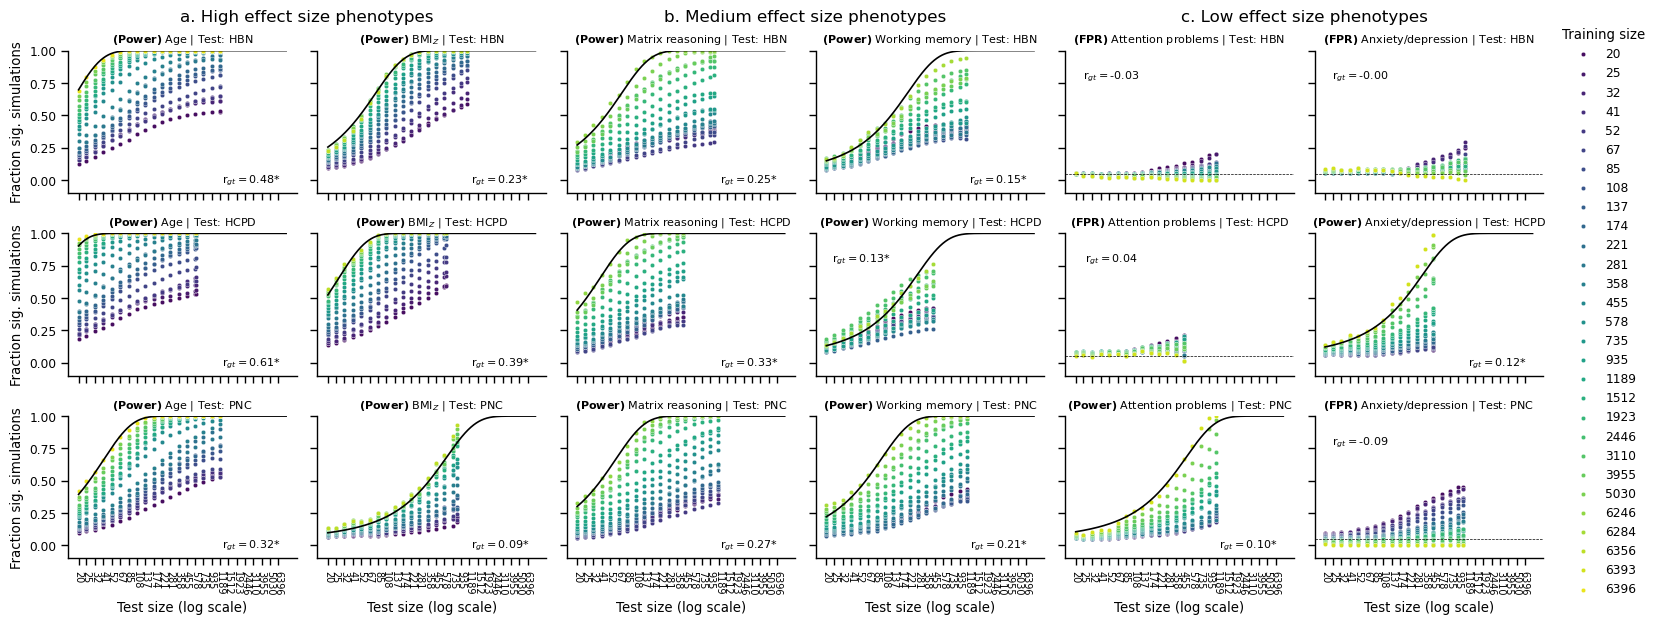

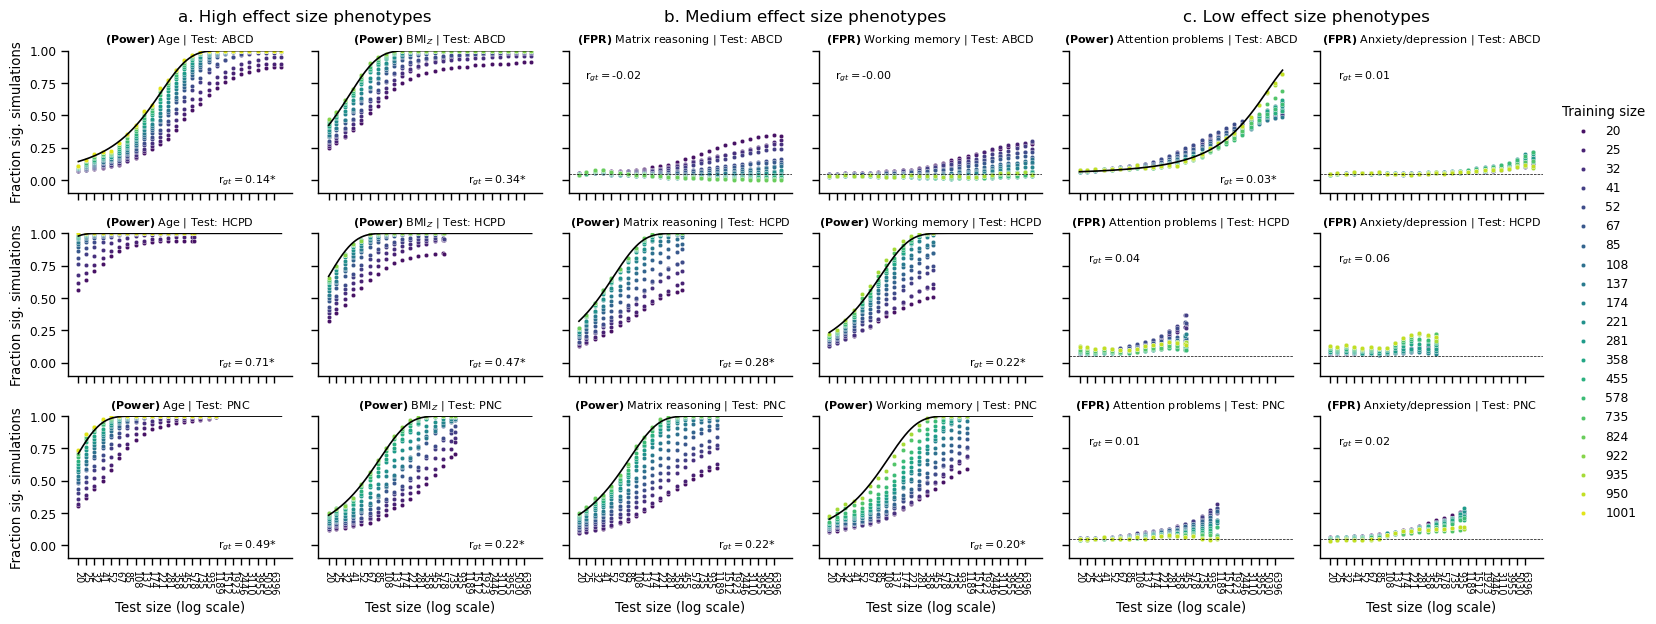

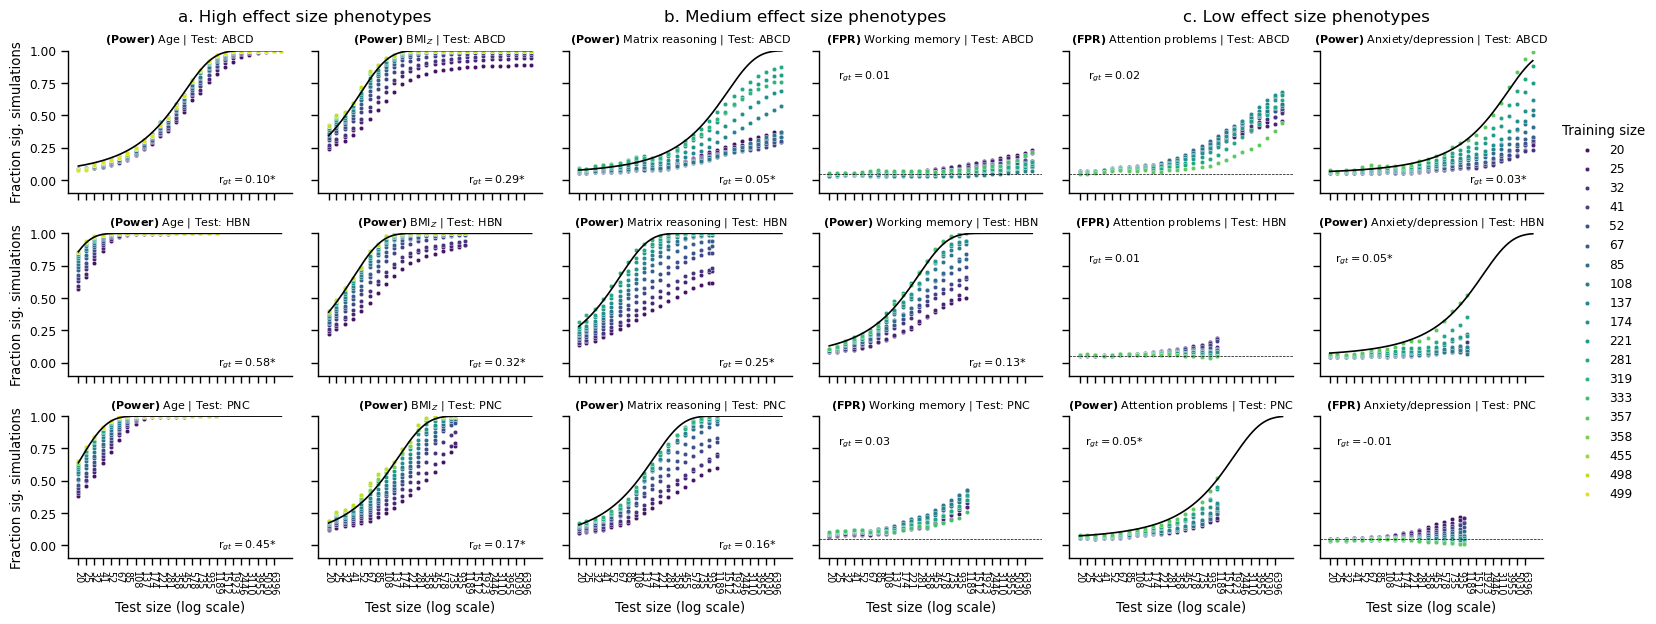

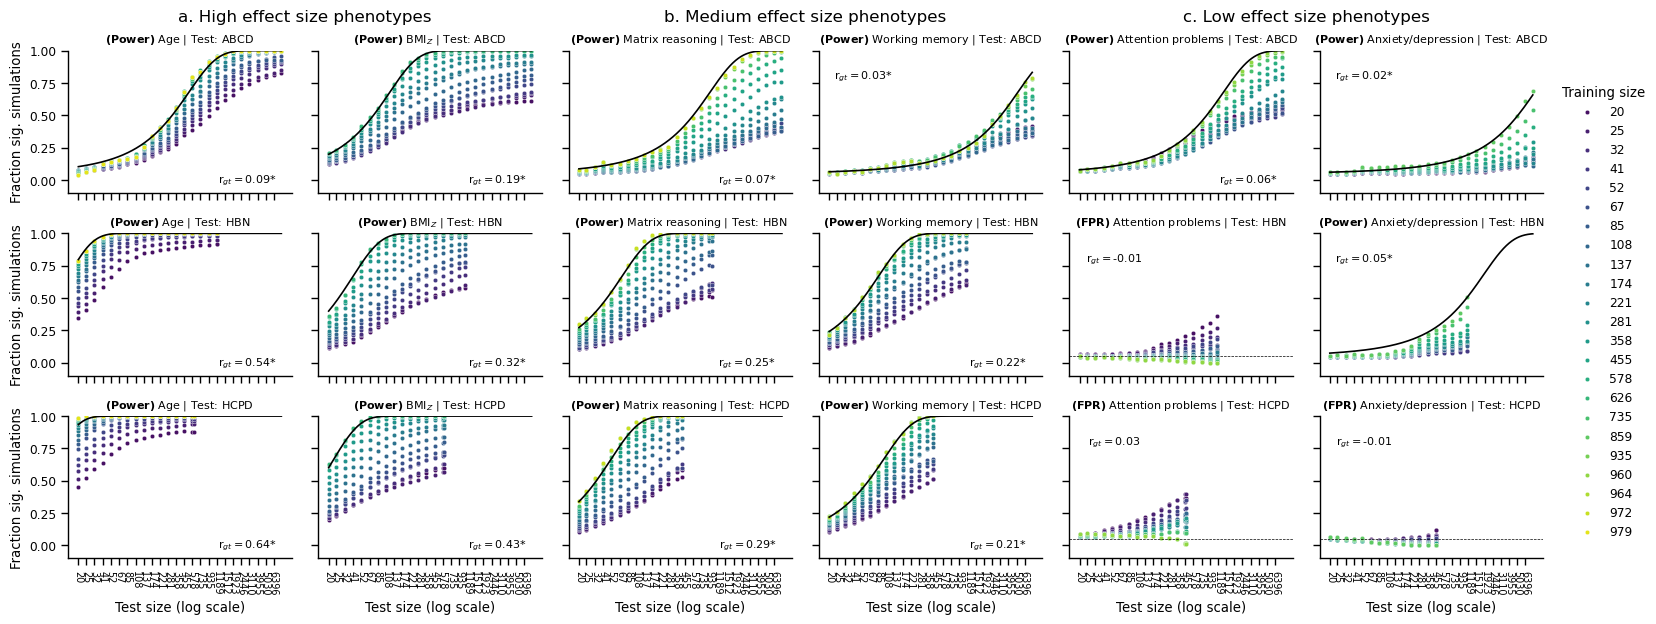

In [16]:
'''
Main figure for power in cross-dataset predictions 
'''
sns.set_context('paper')

# set plot parameters based on analysis type
if analysis_type=='main':
    height = 2
    aspect = 1.3
    col_order=['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    all_datasets = ['abcd', 'hbn', 'hcpd', 'pnc']
elif analysis_type=='dev_sc':
    col_order = ['age', 'wm', 'ad']
    all_datasets = ['hbn_sc', 'hcpd_sc', 'qtab_sc']
    height = 2.2
    aspect = 1.3
elif analysis_type=='adult_fc':
    col_order = ['age', 'rel', 'shape']
    all_datasets = ['chcp', 'hcp']
    height = 2.2
    aspect = 1.3
elif analysis_type=='adult_sc':
    col_order = ['age', 'rel', 'match']
    all_datasets = ['chcp_sc', 'hcp_sc']
    height = 2.2
    aspect = 1.3
elif analysis_type=='data_amount_train':
    col_order = ['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    all_datasets = ['abcd_1_scans', 'abcd_2_scans', 'abcd_3_scans', 'abcd_4_scans']
    height = 2
    aspect = 1.3
elif analysis_type=='data_amount_test':
    col_order = ['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    all_datasets = ['hbn', 'hcpd', 'pnc']
    height = 2
    aspect = 1.3   

if analysis_type!='data_amount_test':
    title_font_size = 8
else: 
    title_font_size = 7

# loop over training datasets
for train_dataset in all_datasets:
    
    # get plot
    df_plot = df_power_grouped[df_power_grouped.train_dataset==train_dataset].reset_index(drop=True)
    
    # set order of rows/datasets
    if analysis_type!='data_amount_train' and analysis_type!='data_amount_test':
        row_order = [d for d in all_datasets if d!=train_dataset]
    elif analysis_type=='data_amount_train':
        row_order = ['hbn', 'hcpd', 'pnc']
    elif analysis_type=='data_amount_test':
        row_order = ['abcd_1_scans', 'abcd_2_scans', 'abcd_3_scans', 'abcd_4_scans']
    rowvar = 'test_dataset'


    # make facet grid
    g = sns.FacetGrid(df_plot, col="pheno",  row=rowvar, hue='num_train',
                      palette=sns.color_palette("viridis", len(df_plot.num_train.unique())),
                     row_order=row_order, col_order=col_order,
                     height=height, aspect=aspect)
    g.map(sns.scatterplot, "num_test", eval_metric+"_pos_rate", s=10).set(xscale = 'log')
    g.set_xlabels('Test size (log scale)')
    g.add_legend(title='Training size')
    g.set(ylim=[-0.1, 1])

    # iterate over axes of FacetGrid
    for i, ax in enumerate(g.axes.flat):
        ax.set_xticks([], minor=True)  # remove minor xticks
        ax.set_xticks([s for s in df_power_grouped.num_test.unique() if s in possible_n])
        ax.xaxis.set_major_formatter(ScalarFormatter())

        for tick in ax.get_xticklabels():
            tick.set_rotation(270)
        # change the fontsize
        ax.tick_params(axis='x', labelsize=7)

        # get plots for theoretical power curves
        title_txt = g.axes.flat[i].title.get_text()
        txt_tmp = title_txt.split('|')
        txt_tmp = [tmp.split('=') for tmp in txt_tmp]
        pheno_name = txt_tmp[1][-1].strip()

        # get ground truth values - depends on how many training datasets
        test_dataset_name = txt_tmp[0][-1].strip()
        eval_metric_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                            (df_plot.test_dataset==test_dataset_name), 
                             eval_metric+'_ground_truth'].mean()  # mean should be the same as taking first
        sig_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                (df_plot.test_dataset==test_dataset_name), 
                 eval_metric+'_sig_ground_truth'].mean()   
        if eval_metric=='mae':  # normalize for MAE
            eval_metric_gt = eval_metric_gt / range_dict[pheno_name]
        # get max power
        max_power = df_plot.loc[(df_plot.pheno==pheno_name) & 
                (df_plot.test_dataset==test_dataset_name), 
                 eval_metric+'_pos_rate'].max()

        # replace phenotype names for plot
        pheno_name = pheno_name_dict[pheno_name]

        if analysis_type=='main':
            N_all = np.arange(20, 8000)
        elif analysis_type=='dev_sc':
            N_all = np.arange(20, 2000)
        elif 'adult' in analysis_type:
            N_all = np.arange(20, 1200)
        elif analysis_type=='data_amount_train':
            N_all = np.arange(20, 1400)
        elif analysis_type=='data_amount_test':
            N_all = np.arange(20, 4000)

        # update titles and add ground truth performance
        if sig_gt==1:
            ax.set_title(r'$\bf{(Power)}$' + ' ' + pheno_name + ' | Test: ' + test_dataset_name.upper().replace('_', '-'),
                         fontsize=title_font_size)



            # put ground truth performance on plot, change location based on max power            
            if max_power>0.8:
                ax.text(0.8, 0, eval_metric+'$_{gt}=$' + '{:.2f}*'.format(eval_metric_gt),
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.get_yaxis_transform(),
                       fontsize=8)       
            else:
                ax.text(0.2, 0.8, eval_metric+'$_{gt}=$' + '{:.2f}*'.format(eval_metric_gt),
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.get_yaxis_transform(),
                       fontsize=8) 
        elif sig_gt==0:  # false positive rate

            # add false positive rate 0.05 line         
            ax.axhline(y=0.05, color='black', linestyle='--', linewidth=0.5)

            ax.set_title(r'$\bf{(FPR)}$' + ' ' + pheno_name + ' | Test: ' + test_dataset_name.upper().replace('_', '-'),
                         fontsize=title_font_size)

            # put ground truth performance on plot
            ax.text(0.2, 0.8, eval_metric+'$_{gt}=$' + '{:.2f}'.format(eval_metric_gt),
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.get_yaxis_transform(),
                       fontsize=8)

        # add power curve
        if sig_gt==1 and eval_metric=='r':  # power
            power_curve = power_curve_1t(eval_metric_gt, N_all)
            ax.plot(N_all, power_curve, color='black')

        # set y label
        ax.set_ylabel('Fraction sig. simulations')

    # add effect size group titles
    effect_size_groups = ['a. High effect size phenotypes','b. Medium effect size phenotypes','c. Low effect size phenotypes']
    # want d, e, f for certain figure
    if analysis_type=='data_amount_train' and train_dataset=='abcd_4_scans':
        effect_size_groups = [e.replace('a. ', 'd. ').replace('b. ', 'e. ').replace('c. ', 'f. ') for e in effect_size_groups]
    title_count = 0
    if analysis_type=='main' or 'data_amount' in analysis_type:  # for main analysis, have 6 pheno
        for i in range(0, g.axes.shape[-1], 2):
            pos1 = g.axes[0, i].get_position()
            pos2 = g.axes[0, i+1].get_position()

            new_pos = 0.25*(pos1.x0 + pos1.x1 + pos2.x0 + pos2.x1)

            g.fig.text(new_pos, 1, effect_size_groups[title_count], ha='center', va='center', fontsize=12)
            title_count+=1   
    elif analysis_type=='dev_sc': 
        for i in range(0, g.axes.shape[-1], 1):
            pos1 = g.axes[0, i].get_position()

            new_pos = 0.5*(pos1.x0 + pos1.x1)

            # want d, e, f instead of a, b, c just for power plot
            title_tmp = effect_size_groups[title_count].replace('a. ', 'd. ').replace('b. ', 'e. ').replace('c. ', 'f. ')
            
            g.fig.text(new_pos, 1, title_tmp, ha='center', va='center', fontsize=10)
            title_count+=1       

#     # save figure
#     g.savefig(os.path.join(fig_path, 'power', 'power_' + train_dataset + '.png'),
#               dpi=400, bbox_inches='tight')

Printing some power summary stats

In [17]:
'''
Can use this to print power for various conditions
'''
sample_size_percentile = '75'  # options: '25' 'med' '75'
if sample_size_percentile=='med':
    num_train_to_print = 137
    num_test_to_print = 108
elif sample_size_percentile=='25':
    num_train_to_print = 52
    num_test_to_print = 52
elif sample_size_percentile=='75':
    num_train_to_print = 358
    num_test_to_print = 281
    
# add in high/med/low effect size
df_power_grouped['effect_size_group'] = df_power_grouped['r_ground_truth'].apply(lambda x: 'high' if x>=0.4 else  
                                         ('medium' if 0.15<=x<0.4 else 'low'  ) )

# restrict to specific sample sizes
df_print = df_power_grouped[(df_power_grouped.num_train==num_train_to_print) & 
                           (df_power_grouped.num_test==num_test_to_print)].reset_index(drop=True).reset_index(drop=True)

# group and display
df_print.groupby(['effect_size_group','r_sig_ground_truth'],
                         as_index=False).agg(power_med=('r_pos_rate', 'median'),
                                             power_min=('r_pos_rate', 'min'),
                                            power_max=('r_pos_rate', 'max'))



effect_size_group  r_sig_ground_truth  power_med  power_min  power_max
0              high                 1.0    1.00000     0.9098     1.0000
1               low                 0.0    0.07480     0.0112     0.1588
2               low                 1.0    0.18830     0.0780     0.6867
3            medium                 1.0    0.93545     0.3452     1.0000

# Effect size inflation

In [18]:
# load effect size inflation data
df_effect_size = pd.read_csv(os.path.join(load_path, 'effect_size.csv') )

# remove scaled phenotypes
df_effect_size = df_effect_size[(df_effect_size.pheno!='mr_scaled') & 
                                   (df_effect_size.pheno!='wm_corrected')].reset_index(drop=True)

# restrict to only r or MAE
df_effect_size = df_effect_size[df_effect_size.eval_metric==eval_metric].reset_index(drop=True)

if eval_metric=='mae':  # for MAE, normalize metric range
    keys_to_normalize = ['mae_infl_med', 'mae_ground_truth']#  [k for k in df_performance_grouped.keys() if ('mae' in k and '_sig_' not in k)]
    for k in keys_to_normalize:
        df_effect_size[k] = df_effect_size.apply(lambda x: x[k]/range_dict[x.pheno], axis=1)
elif eval_metric=='r':  # fix column naming
    df_effect_size = df_effect_size.rename(columns={'sig_external':'sig_external_r'})
    
df_effect_size.head()


train_dataset test_dataset pheno  num_train  num_test  sig_external_r  \
0          abcd          hbn   age         20        20             0.0   
1          abcd          hbn   age         20        20             1.0   
2          abcd          hbn   age         20        25             0.0   
3          abcd          hbn   age         20        25             1.0   
4          abcd          hbn   age         20        32             0.0   

      r_med  r_ground_truth  r_sig_ground_truth    mae_med  mae_ground_truth  \
0  0.020020         0.48106                 1.0  34.682150         34.615652   
1  0.471284         0.48106                 1.0  36.206917         34.615652   
2  0.016043         0.48106                 1.0  34.589289         34.615652   
3  0.426695         0.48106                 1.0  35.278881         34.615652   
4  0.009299         0.48106                 1.0  34.608665         34.615652   

   mae_sig_ground_truth  r_infl_med  mae_infl_med eval_metric  \
0                   1.0   -0.461040      0.066498           r   
1                   1.0   -0.009776      1.591266           r   
2                   1.0   -0.465017     -0.026363           r   
3                   1.0   -0.054364      0.663229           r   
4                   1.0   -0.471761     -0.006987           r   

   sig_external_mae  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN

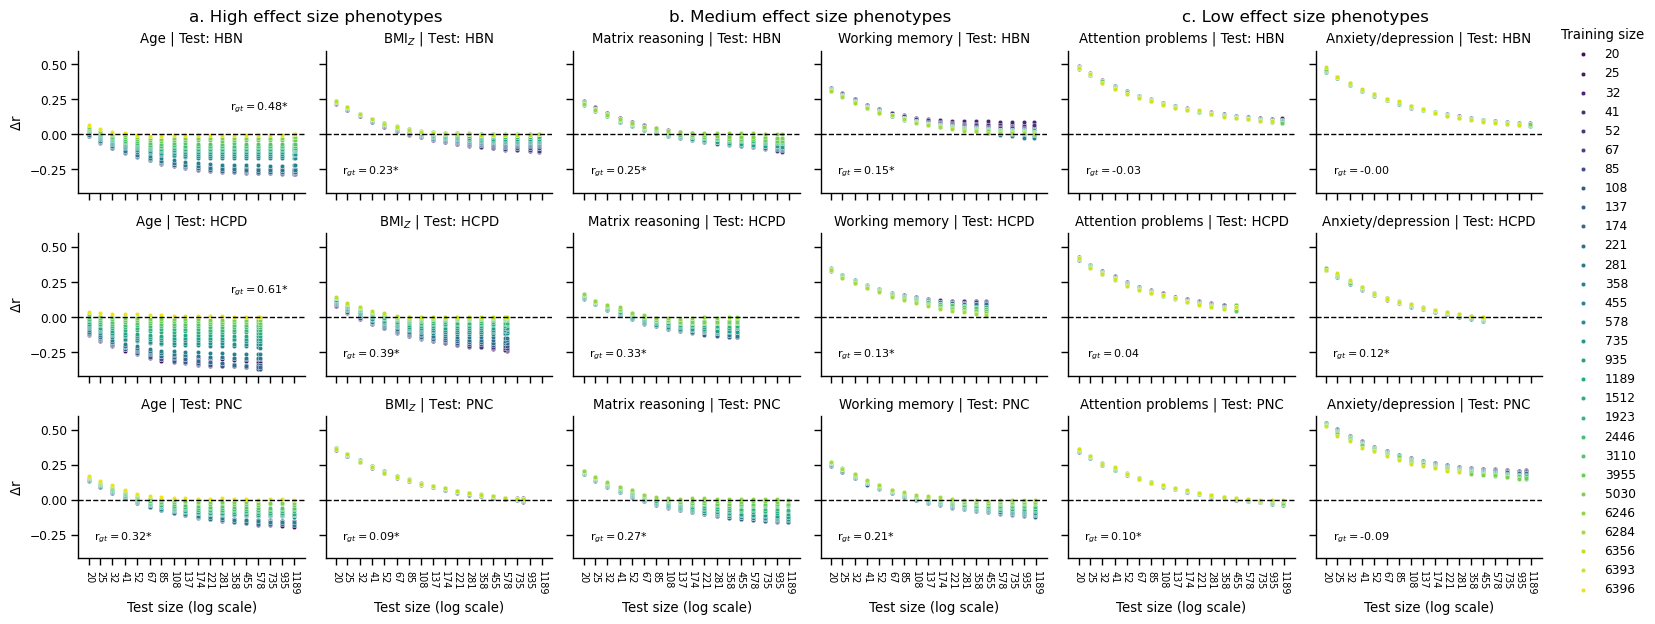

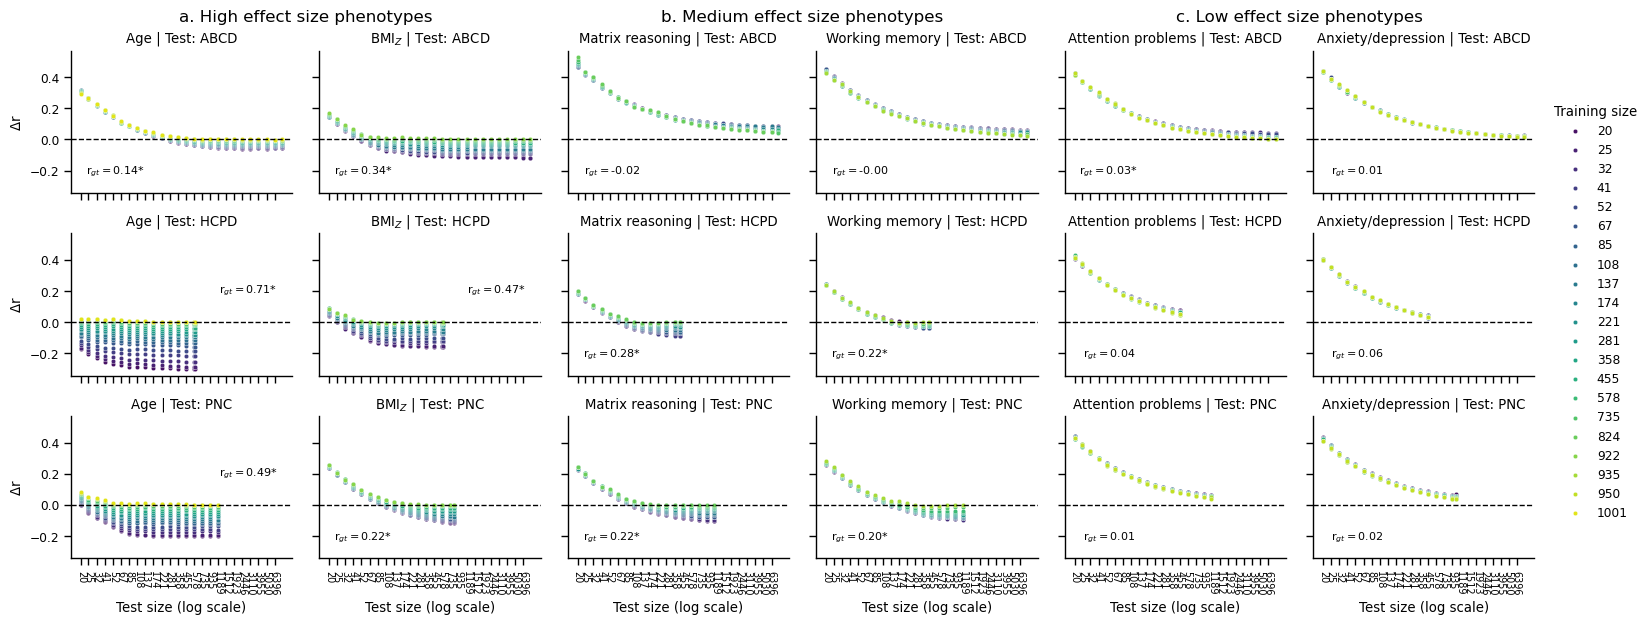

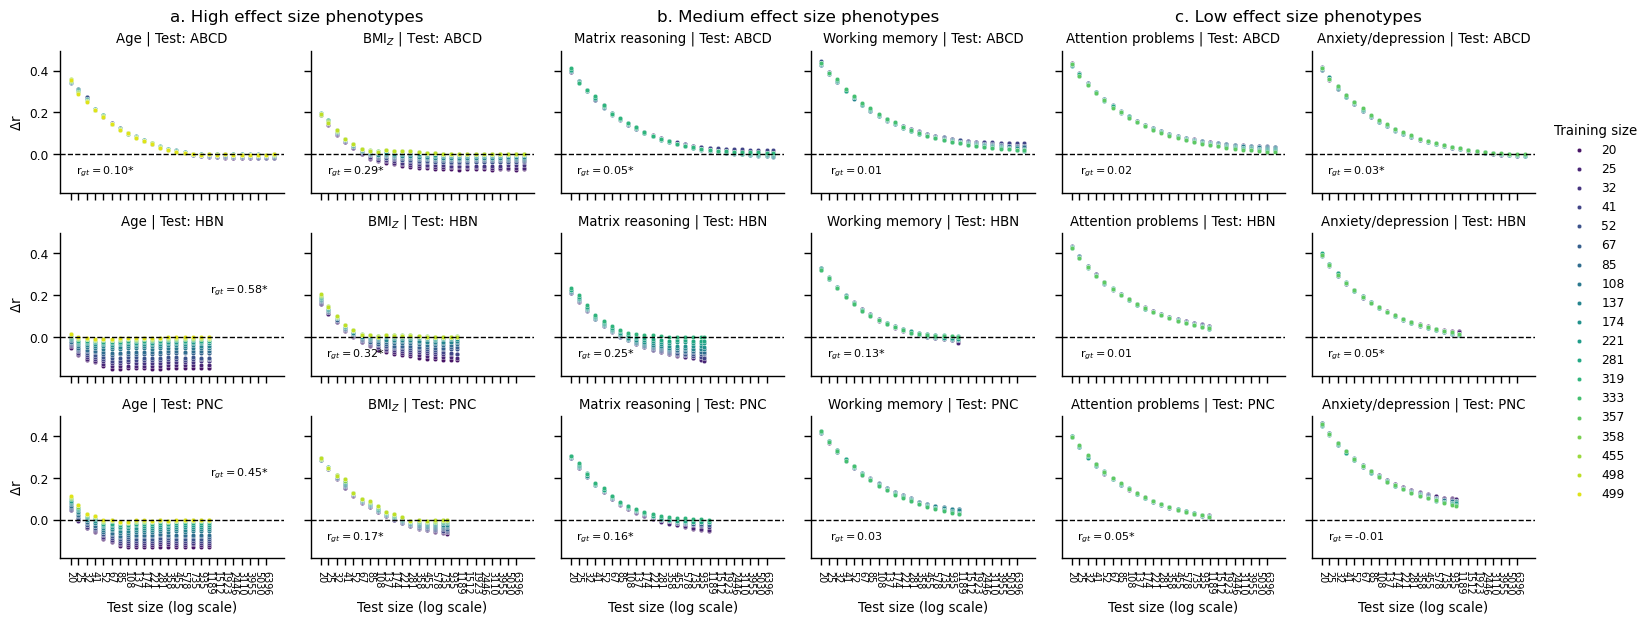

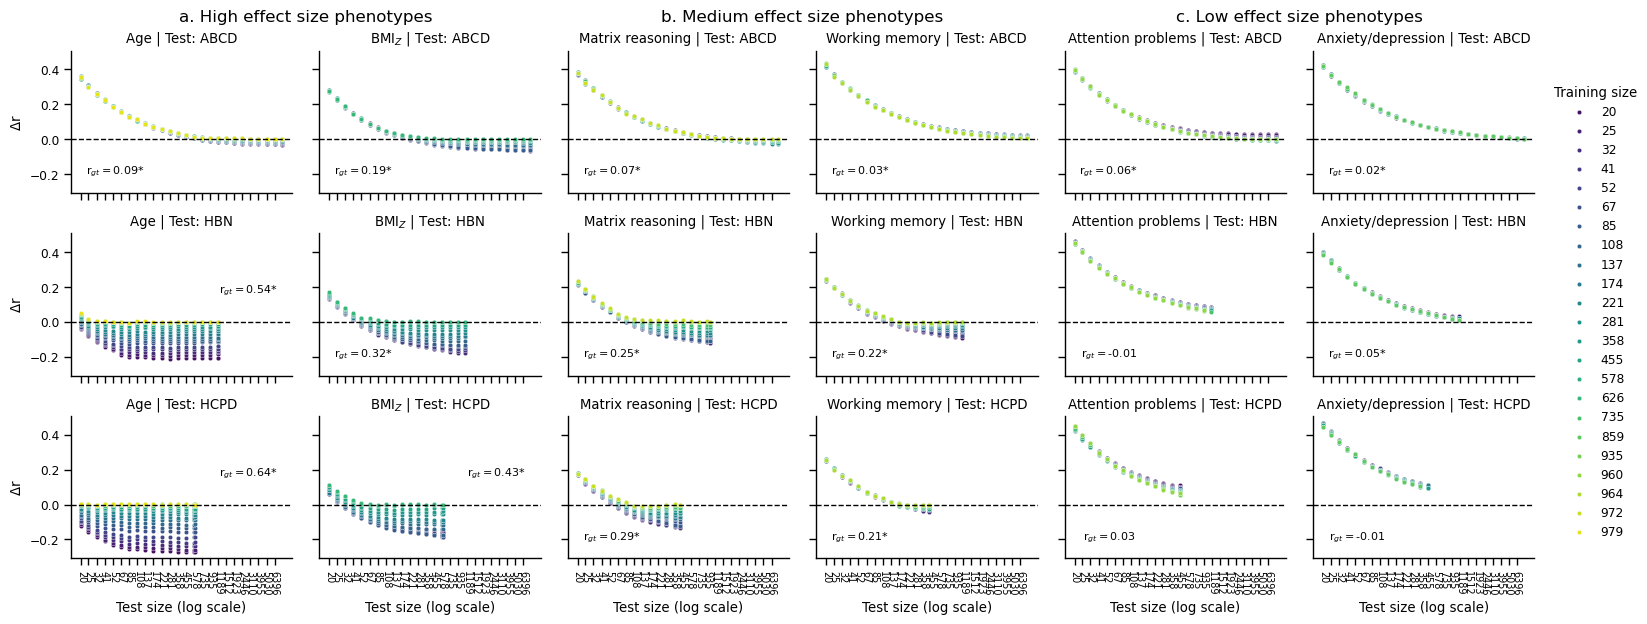

In [19]:
sns.set_context('paper')

# set plot parameters based on analysis type
if analysis_type=='main':
    height = 2
    aspect = 1.3
    col_order=['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    all_datasets = ['abcd', 'hbn', 'hcpd', 'pnc']
elif analysis_type=='dev_sc':
    col_order = ['age', 'wm', 'ad']
    all_datasets = ['hbn_sc', 'hcpd_sc', 'qtab_sc']
    height = 2.2
    aspect = 1.3
elif analysis_type=='adult_fc':
    col_order = ['age', 'rel', 'shape']
    all_datasets = ['chcp', 'hcp']
    height = 2.2
    aspect = 1.3
elif analysis_type=='adult_sc':
    col_order = ['age', 'rel', 'match']
    all_datasets = ['chcp_sc', 'hcp_sc']
    height = 2.2
    aspect = 1.3
elif analysis_type=='data_amount_train':
    col_order = ['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    all_datasets = ['abcd_1_scans', 'abcd_2_scans', 'abcd_3_scans', 'abcd_4_scans']
    height = 2
    aspect = 1.3
if analysis_type=='data_amount_test':
    height = 2
    aspect = 1.3
    col_order=['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    all_datasets = ['hbn', 'hcpd', 'pnc'] 
    
# loop over all datasets
for train_dataset in all_datasets:

    # get only training dataset of interest and those with significant results (for purpose of evaluating effect size inflation)
    df_plot = df_effect_size[(df_effect_size.train_dataset==train_dataset) & 
                        (df_effect_size['sig_external_'+eval_metric]==1)].reset_index(drop=True)
    if analysis_type!='data_amount_train' and analysis_type!='data_amount_test':
        row_order = [d for d in all_datasets if d!=train_dataset]
    elif analysis_type=='data_amount_train':
        row_order = ['hbn', 'hcpd', 'pnc']
    elif analysis_type=='data_amount_test':
        row_order = ['abcd_1_scans', 'abcd_2_scans', 'abcd_3_scans', 'abcd_4_scans']
    rowvar = 'test_dataset'

    # share y axes for r, not for mae
    if eval_metric=='mae':
        sharey=False
    else:
        sharey=True

    # CAN CHANGE PHENOTYPE HERE
    g = sns.FacetGrid(df_plot, col="pheno",  row=rowvar, hue='num_train',
                     row_order=row_order, col_order=col_order,
                     palette=sns.color_palette("viridis", len(df_plot.num_train.unique())),
                     height=height, aspect=aspect, sharey=sharey)
    g.map(sns.scatterplot, "num_test", eval_metric+"_infl_med", s=10).set(xscale = 'log')
    g.set_xlabels('Test size (log scale)')
    g.add_legend(title='Training size')

    # iterate over axes of FacetGrid
    for i, ax in enumerate(g.axes.flat):
        ax.set_xticks([], minor=True)  # remove minor xticks
        ax.set_xticks([s for s in df_plot.num_test.unique() if s in possible_n])
        ax.xaxis.set_major_formatter(ScalarFormatter())

        for tick in ax.get_xticklabels():
            tick.set_rotation(270)
        ax.tick_params(axis='x', labelsize=7)

        # get plots for theoretical power curves
        title_txt = g.axes.flat[i].title.get_text()
        txt_tmp = title_txt.split('|')
        txt_tmp = [tmp.split('=') for tmp in txt_tmp]
        pheno_name = txt_tmp[1][-1].strip()


        # get ground truth values - depends on how many training datasets
        test_dataset_name = txt_tmp[0][-1].strip()


        eval_metric_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                            (df_plot.test_dataset==test_dataset_name), 
                             eval_metric+'_ground_truth'].mean()  # mean should be the same as taking first
        sig_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                    (df_plot.test_dataset==test_dataset_name), 
                     eval_metric+'_sig_ground_truth'].mean()   



        # replace phenotype names for plot
        pheno_name = pheno_name_dict[pheno_name]

        if sig_gt==1:
            sig_gt_str='*'
        else:
            sig_gt_str=''



        if ~np.isnan(eval_metric_gt):

            ax.set_title(pheno_name + ' | Test: ' + test_dataset_name.upper().replace('_', '-'))


            # location of ground truth annotation
            if eval_metric=='r':
                if eval_metric_gt>.4:
                    gt_yloc = 0.6
                    gt_xloc = 0.8
                else:
                    gt_yloc = 0.15
                    gt_xloc = 0.2
                gt_fontsize=8
            elif eval_metric=='mae':
                gt_xloc = 0.9
                gt_yloc = 0.04
                gt_fontsize=6

            # put ground truth performance on plot
            ax.text(gt_xloc, gt_yloc, eval_metric+'$_{gt}=$' + '{:.2f}'.format(eval_metric_gt) + sig_gt_str,
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ax.transAxes, fontsize=8)

            # add r=0 line
            ax.axhline(0, linestyle='--', color='black', lw=1)


        ax.set_ylabel('$\Delta $' + eval_metric)

    # add effect size group titles
    effect_size_groups = ['a. High effect size phenotypes','b. Medium effect size phenotypes','c. Low effect size phenotypes']
    title_count = 0
    if analysis_type=='main':  # for main analysis, have 6 pheno
        for i in range(0, g.axes.shape[-1], 2):
            pos1 = g.axes[0, i].get_position()
            pos2 = g.axes[0, i+1].get_position()

            new_pos = 0.25*(pos1.x0 + pos1.x1 + pos2.x0 + pos2.x1)

            g.fig.text(new_pos, 1, effect_size_groups[title_count], ha='center', va='center', fontsize=12)
            title_count+=1   
    elif analysis_type=='dev_sc': 
        for i in range(0, g.axes.shape[-1], 1):
            pos1 = g.axes[0, i].get_position()

            new_pos = 0.5*(pos1.x0 + pos1.x1)

            g.fig.text(new_pos, 1, effect_size_groups[title_count], ha='center', va='center', fontsize=10)
            title_count+=1       


#     g.savefig(os.path.join(fig_path, 'inflation/inflation_' + train_dataset + '.png'),
#               dpi=400, bbox_inches='tight')


printing out inflations at various sample sizes

In [20]:
'''
print out inflation by sample size
'''

if eval_metric=='r':

    sample_size_percentile = '75'  # options: '25' 'med' '75'
    if sample_size_percentile=='med':
        num_train_to_print = 137
        num_test_to_print = 108
    elif sample_size_percentile=='25':
        num_train_to_print = 52
        num_test_to_print = 52
    elif sample_size_percentile=='75':
        num_train_to_print = 358
        num_test_to_print = 281

    # add in high/med/low effect size
    df_effect_size['effect_size_group'] = df_effect_size['r_ground_truth'].apply(lambda x: 'high' if x>=0.4 else  
                                             ('medium' if 0.15<=x<0.4 else 'low'  ) )

    df_effect_size.head()
    # restrict to specific sample sizes, also only sig results
    df_print = df_effect_size[(df_effect_size.sig_external_r==1) & 
                              (df_effect_size.num_train==num_train_to_print) & 
                               (df_effect_size.num_test==num_test_to_print)].reset_index(drop=True).reset_index(drop=True)

    # group and display
    print('*************************{:s}*****************************************'.format(sample_size_percentile))
    df_print.groupby(['effect_size_group', 'sig_external_r'],
                             as_index=False).agg(inl_med=('r_infl_med', 'median'),
                                                 infl_min=('r_infl_med', 'min'),
                                                infl_max=('r_infl_med', 'max'))


*************************75*****************************************


# Relating internal and external performance

In [21]:
# load in data with full test set for comparison of internal/external performance
df_fulltest = pd.read_csv(os.path.join(load_path, 'full_test.csv') )

# restrict phenotypes
if analysis_type=='main':
    df_fulltest = df_fulltest[df_fulltest.pheno.isin(['age', 'bmi', 'mr', 'wm', 'ap', 'ad'])].reset_index(drop=True)

# fix sign so internal minus external
df_fulltest['r_internal_external_diff'] = -1*df_fulltest['r_internal_external_diff']
df_fulltest['mae_internal_external_diff'] = -1*df_fulltest['mae_internal_external_diff']

# for MAE, normalize metric range
if eval_metric=='mae':
    keys_to_normalize = ['mae_internal_external_diff', 'mae_internal', 'mae_external']
    for k in keys_to_normalize:
        df_fulltest[k] = df_fulltest.apply(lambda x: x[k]/range_dict[x.pheno], axis=1)

zero_clip = False
# clip negative performance to zero
if zero_clip and eval_metric=='r':
    df_fulltest[eval_metric+'_internal'] = df_fulltest[eval_metric+'_internal'].clip(lower=0)
    df_fulltest[eval_metric+'_external'] = df_fulltest[eval_metric+'_external'].clip(lower=0)
    df_fulltest[eval_metric+'_internal_external_diff'] = df_fulltest[eval_metric+'_internal'] -\
                                                    df_fulltest[eval_metric+'_external']

df_fulltest.head()

train_dataset pheno test_dataset  train_seed  num_train  test_seed  \
0          abcd   age          hbn          94       1923          0   
1          abcd   age          hbn          82        174          0   
2          abcd   age          hbn          68        578          0   
3          abcd   age          hbn          19         41          0   
4          abcd   age          hbn          27        578          0   

   num_test  r_internal  q2_internal  mae_internal  ...  p_mae_gt  \
0      1201    0.142898    -0.026209      6.338037  ...     0.002   
1      1201    0.114474    -0.138591      6.679720  ...     0.002   
2      1201    0.044382    -0.302491      7.129295  ...     0.002   
3      1201    0.035483    -0.016094      6.678008  ...     0.002   
4      1201    0.117848    -0.049780      6.480519  ...     0.002   

   p_mae_gt_internal  sig_internal  sig_external  sig_gt  sig_internal_mae  \
0              0.002           1.0           1.0     1.0               1.0   
1              0.002           1.0           1.0     1.0               1.0   
2              0.002           1.0           1.0     1.0               1.0   
3              0.002           0.0           1.0     1.0               0.0   
4              0.002           1.0           1.0     1.0               1.0   

   sig_external_mae  sig_gt_mae  r_internal_external_diff  \
0               1.0         1.0                 -0.388064   
1               1.0         1.0                 -0.152025   
2               1.0         1.0                 -0.148249   
3               1.0         1.0                 -0.075699   
4               1.0         1.0                 -0.198703   

   mae_internal_external_diff  
0                  -27.810340  
1                  -27.802472  
2                  -27.340754  
3                  -28.865930  
4                  -28.443944  

[5 rows x 39 columns]

In [22]:
# calculate median difference between internal/external
df_external_internal = df_fulltest.groupby(['train_dataset', 'test_dataset', 'pheno', 'num_train', 'num_test'],
                      as_index=False).agg(internal_external_diff_med=(eval_metric+'_internal_external_diff', 'median'))
df_external_internal.head()

train_dataset test_dataset pheno  num_train  num_test  \
0          abcd          hbn    ad         20      1150   
1          abcd          hbn    ad         25      1150   
2          abcd          hbn    ad         32      1150   
3          abcd          hbn    ad         41      1150   
4          abcd          hbn    ad         52      1150   

   internal_external_diff_med  
0                   -0.010090  
1                   -0.017673  
2                   -0.018496  
3                   -0.013556  
4                    0.000137

abcd
['a. High effect size phenotypes', 'b. Medium effect size phenotypes', 'c. Low effect size phenotypes']
hbn
['a. High effect size phenotypes', 'b. Medium effect size phenotypes', 'c. Low effect size phenotypes']
hcpd
['a. High effect size phenotypes', 'b. Medium effect size phenotypes', 'c. Low effect size phenotypes']
pnc
['a. High effect size phenotypes', 'b. Medium effect size phenotypes', 'c. Low effect size phenotypes']


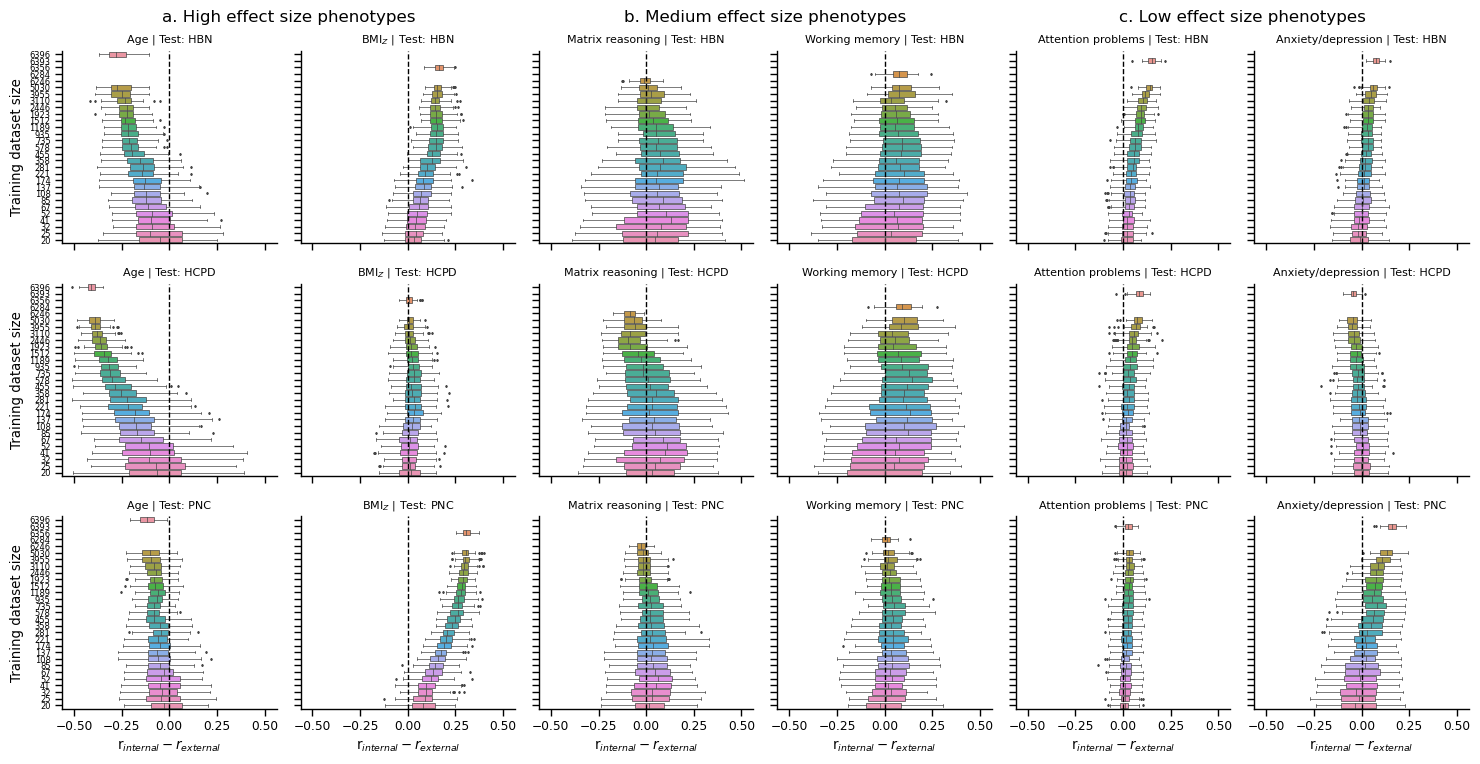

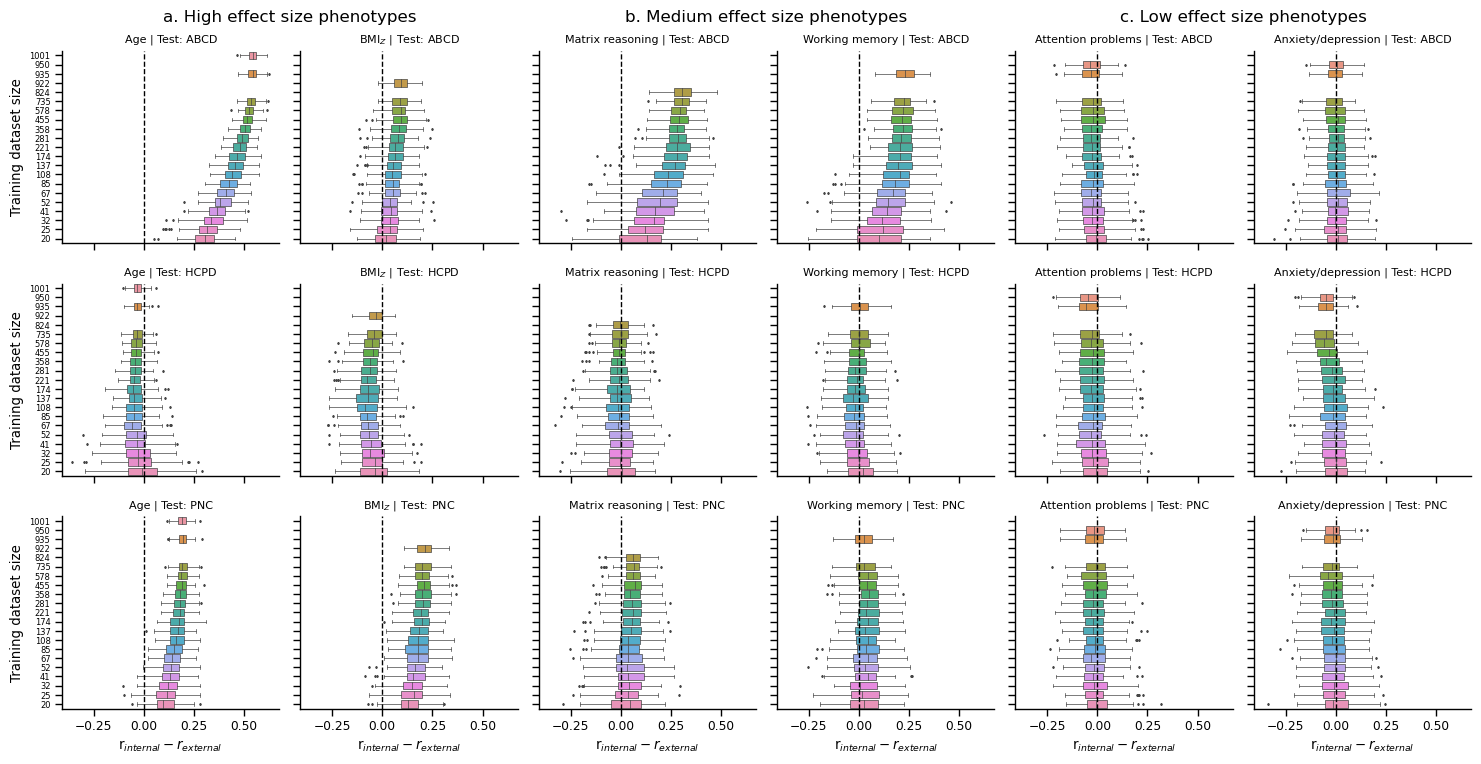

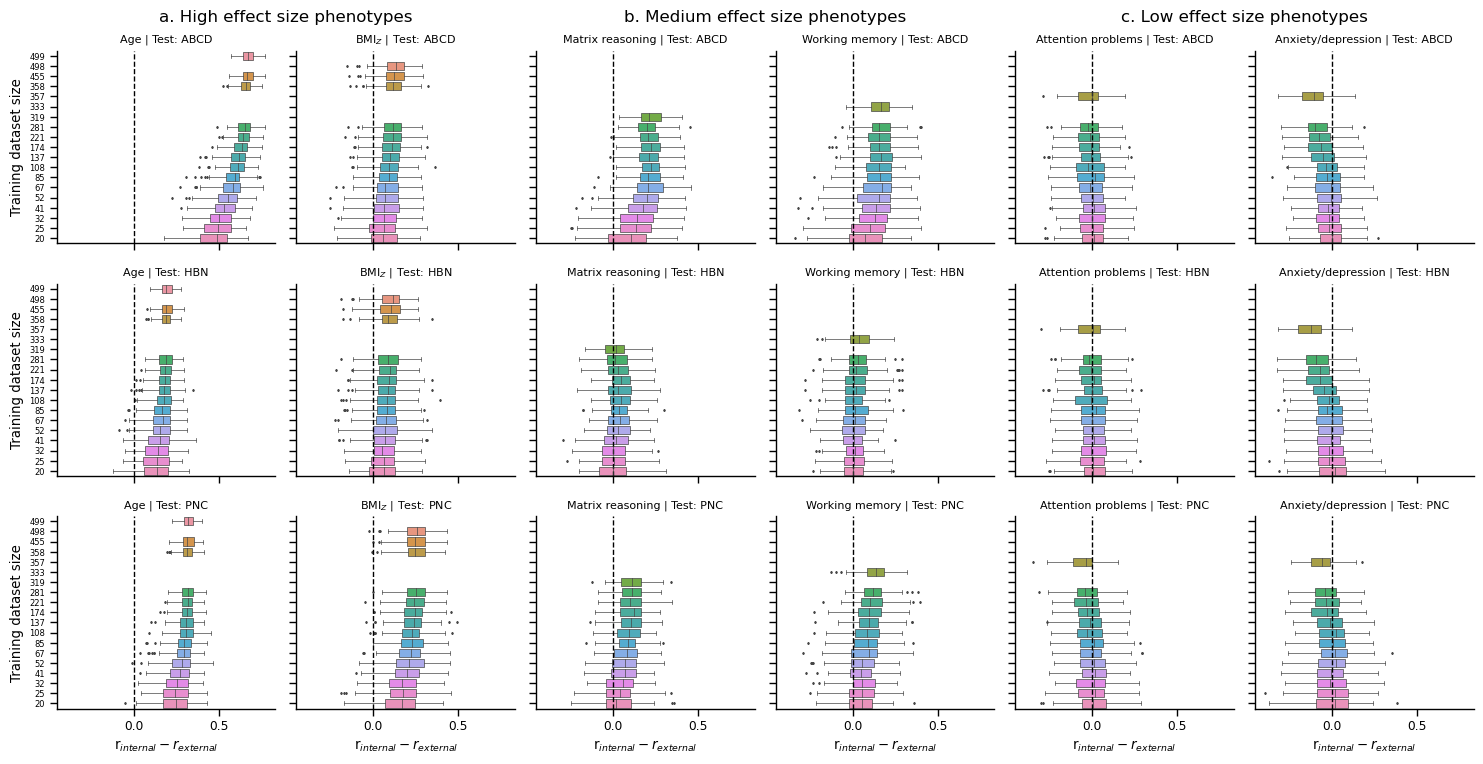

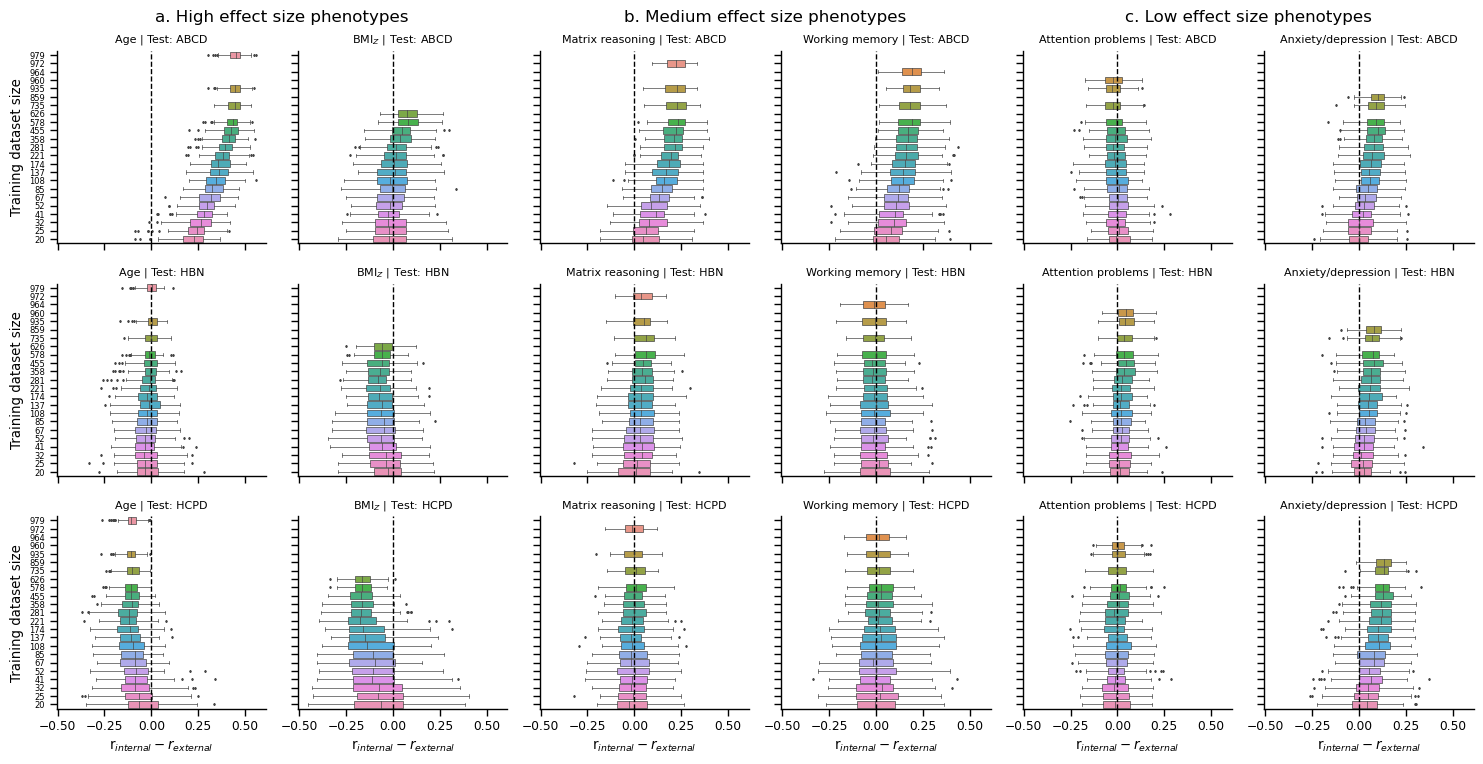

In [23]:
sns.set_context('paper')

# set plot parameters based on analysis type
if analysis_type=='main':
    col_order=['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    all_datasets = ['abcd', 'hbn', 'hcpd', 'pnc']
    aspect = 1
    height=2.5
elif analysis_type=='dev_sc':
    aspect = 1
    height=2.8
    col_order = ['age', 'wm', 'ad']
    all_datasets = ['hbn_sc', 'hcpd_sc', 'qtab_sc']
elif analysis_type=='adult_fc':
    col_order = ['age', 'rel', 'shape']
    all_datasets = ['chcp', 'hcp']
    aspect = 1
    height=2.8
elif analysis_type=='adult_sc':
    col_order = ['age', 'rel', 'match']
    all_datasets = ['chcp_sc', 'hcp_sc']
    aspect = 1
    height=2.8
elif analysis_type=='data_amount_train':
    col_order=['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    all_datasets = ['abcd_1_scans', 'abcd_2_scans', 'abcd_3_scans', 'abcd_4_scans']
    aspect = 1
    height=2.5
elif analysis_type=='data_amount_test':
    col_order=['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    all_datasets = ['hbn', 'hcpd', 'pnc']
    aspect = 1
    height=2.5
    
# don't share axes for MAE
if eval_metric=='mae':
    sharex=False
    sharey=True
else:
    sharex=True
    sharey=True
    
# loop over train dataset
for train_dataset_name in all_datasets: 

    # restrict dataframe to datasets of interest
    df_plot = df_fulltest[(df_fulltest.train_dataset==train_dataset_name)].reset_index(drop=True)

    # convert to string to avoid log scaling catplot issue in seaborn
    df_plot['num_train'] = df_plot['num_train'].astype('str')  

    # get row order (test datasets)
    if analysis_type!='data_amount_train' and analysis_type!='data_amount_test':
        row_order = [d for d in all_datasets if d!=train_dataset_name]
    elif analysis_type=='data_amount_train':
        row_order = ['hbn', 'hcpd', 'pnc']
    elif analysis_type=='data_amount_test':
        row_order = ['abcd_1_scans', 'abcd_2_scans', 'abcd_3_scans', 'abcd_4_scans']
    
    g = sns.catplot(
        data=df_plot, x=eval_metric+'_internal_external_diff', y='num_train',
        col='pheno', row='test_dataset', kind='box', 
        row_order=row_order,
        col_order=col_order,
        order=[str(val) for val in np.sort(df_plot.num_train.unique().astype(int))[::-1] ],
        aspect=aspect,
        height=height,
        margin_titles=False,
        linewidth=0.5, fliersize=1,
        sharex=sharex, sharey=sharey
    )
    g.set_axis_labels(eval_metric+'$_{internal} - ' + eval_metric+ '_{external}$', 'Training dataset size')


    # iterate over axes of FacetGrid
    for i, ax in enumerate(g.axes.flat):

        ax.tick_params(axis='y', labelsize=6)

        # add line
        ax.axvline(x=0, lw=1, linestyle='--', color='black')
        
        # edit title text
        title_txt = g.axes.flat[i].title.get_text()
        txt_tmp = title_txt.split('|')
        txt_tmp = [tmp.split('=') for tmp in txt_tmp]
        pheno_name = txt_tmp[1][-1].strip()
        test_dataset_name = txt_tmp[0][-1].strip()
        ax.set_title(pheno_name_dict[pheno_name] + ' | Test: ' + test_dataset_name.upper().replace('_', '-'),
                     fontsize=8)

    # add effect size group titles
    effect_size_groups = ['a. High effect size phenotypes','b. Medium effect size phenotypes','c. Low effect size phenotypes']
    # want d, e, f for certain figure
    print(train_dataset_name)
    print(effect_size_groups)
    if analysis_type=='data_amount_train' and train_dataset_name=='abcd_4_scans':
        print('in logical statement')
        effect_size_groups = [e.replace('a. ', 'd. ').replace('b. ', 'e. ').replace('c. ', 'f. ') for e in effect_size_groups]
    title_count = 0    
    if analysis_type=='main' or 'data_amount' in analysis_type:  # for main analysis, have 6 pheno
        for i in range(0, g.axes.shape[-1], 2):
            pos1 = g.axes[0, i].get_position()
            pos2 = g.axes[0, i+1].get_position()

            new_pos = 0.25*(pos1.x0 + pos1.x1 + pos2.x0 + pos2.x1)

            g.fig.text(new_pos, 1, effect_size_groups[title_count], ha='center', va='center', fontsize=12)
            title_count+=1   
    elif analysis_type=='dev_sc': 
        for i in range(0, g.axes.shape[-1], 1):
            pos1 = g.axes[0, i].get_position()

            new_pos = 0.5*(pos1.x0 + pos1.x1)

            g.fig.text(new_pos, 1, effect_size_groups[title_count], ha='center', va='center', fontsize=10)
            title_count+=1       



#     if zero_clip:  # change name for zero clip 
#         g.savefig(os.path.join(fig_path, 'internal_external','internal_external_' + train_dataset_name + '_zeroclip.png'),
#                   dpi=400, bbox_inches='tight')
#     else:
#         g.savefig(os.path.join(fig_path, 'internal_external','internal_external_' + train_dataset_name + '.png'),
#                   dpi=400, bbox_inches='tight')

In [24]:
# print inflation, decide whether to restrict to significant results
restrict_to_sig = False

# add in two binary columns for whether it is within threshold
df_fulltest['internal_external_diff_0.2'] = list((df_fulltest['r_internal_external_diff'])<0.2)
df_fulltest['internal_external_diff_0.1'] = list((df_fulltest['r_internal_external_diff'])<0.1)

# add new columns calculating fractional differences
df_fulltest['frac_r'] = (df_fulltest['r_internal'] - df_fulltest['r_external']) / abs(df_fulltest['r_internal'])
df_fulltest['frac_r_1'] = df_fulltest['frac_r']<1
df_fulltest['frac_r_0.5'] = df_fulltest['frac_r']<0.5
df_fulltest['frac_r_0.2'] = df_fulltest['frac_r']<0.2

df_fulltest['frac_mae'] = (df_fulltest['mae_external'] - df_fulltest['mae_internal']) / abs(df_fulltest['mae_internal'])
df_fulltest['frac_mae_1'] = df_fulltest['frac_mae']<1
df_fulltest['frac_mae_0.5'] = df_fulltest['frac_mae']<0.5
df_fulltest['frac_mae_0.2'] = df_fulltest['frac_mae']<0.2


# print results
if restrict_to_sig:  # print in significant internal validation models only

    print('*************In significant internal val models only******************')
    print('difference:')
    print(df_fulltest[ (df_fulltest.sig_internal==1) & 
                     (df_fulltest.num_train.isin([52, 137, 358]))].groupby([ 'num_train'],
                      as_index=False).agg(internal_external_diff_2=('internal_external_diff_0.2', 'mean'),
                                         internal_external_diff_1=('internal_external_diff_0.1', 'mean')) )
    print('Fractional difference for r:')
    print(df_fulltest[ (df_fulltest.sig_internal==1) & 
                     (df_fulltest.num_train.isin([52, 137, 358]))].groupby([ 'num_train'],
                      as_index=False).agg(frac_2=('frac_r_0.2', 'mean'),
                                          frac_5=('frac_r_0.5', 'mean'),
                                         frac_1=('frac_r_1', 'mean'),
                                       ) )
    
    print('Fractional difference for mae:')
    print(df_fulltest[ (df_fulltest.sig_internal_mae==1) & 
                     (df_fulltest.num_train.isin([52, 137, 358]))].groupby([ 'num_train'],
                      as_index=False).agg(frac_2=('frac_mae_0.2', 'mean'),
                                          frac_5=('frac_mae_0.5', 'mean'),
                                         frac_1=('frac_mae_1', 'mean'),
                                         ) )
else:  # print in all models
    # some lines we can add for dev_sc
    '''
    For any QTAB:
    ((df_fulltest.train_dataset=='qtab_sc') | (df_fulltest.test_dataset=='qtab_sc')) &
    
    For testing in QTAB:
    (df_fulltest.test_dataset=='qtab_sc') &
    
    For cross-country
  ((df_fulltest.train_dataset!='hbn_sc') | (df_fulltest.test_dataset!='hcpd_sc')) & 
                      ((df_fulltest.train_dataset!='hcpd_sc') | (df_fulltest.test_dataset!='hbn_sc')) &
    '''
    print('*************In all models******************')
    print('difference:')
    print(df_fulltest[  ((df_fulltest.train_dataset!='hbn_sc') | (df_fulltest.test_dataset!='hcpd_sc')) & 
                      ((df_fulltest.train_dataset!='hcpd_sc') | (df_fulltest.test_dataset!='hbn_sc')) &
                     (df_fulltest.num_train.isin([52, 137, 358]))].groupby([ 'num_train'],
                      as_index=False).agg(internal_external_diff_2=('internal_external_diff_0.2', 'mean'),
                                         internal_external_diff_1=('internal_external_diff_0.1', 'mean')) )
    print('Fractional difference for r:')
    print(df_fulltest[  ((df_fulltest.train_dataset!='hbn_sc') | (df_fulltest.test_dataset!='hcpd_sc')) & 
                      ((df_fulltest.train_dataset!='hcpd_sc') | (df_fulltest.test_dataset!='hbn_sc')) &
                     (df_fulltest.num_train.isin([52, 137, 358]))].groupby([ 'num_train'],
                      as_index=False).agg(frac_2=('frac_r_0.2', 'mean'),
                                          frac_5=('frac_r_0.5', 'mean'),
                                         frac_1=('frac_r_1', 'mean'),
                                       ) )
    
    print('Fractional difference for mae:')
    print(df_fulltest[  ((df_fulltest.train_dataset!='hbn_sc') | (df_fulltest.test_dataset!='hcpd_sc')) & 
                      ((df_fulltest.train_dataset!='hcpd_sc') | (df_fulltest.test_dataset!='hbn_sc')) &
                     (df_fulltest.num_train.isin([52, 137, 358]))].groupby([ 'num_train'],
                      as_index=False).agg(frac_2=('frac_mae_0.2', 'mean'),
                                          frac_5=('frac_mae_0.5', 'mean'),
                                         frac_1=('frac_mae_1', 'mean'),
                                         ) )


*************In all models******************
difference:
   num_train  internal_external_diff_2  internal_external_diff_1
0         52                  0.868333                  0.703472
1        137                  0.850417                  0.675694
2        358                  0.821667                  0.651833
Fractional difference for r:
   num_train    frac_2    frac_5    frac_1
0         52  0.465417  0.588889  0.787500
1        137  0.455417  0.611250  0.824583
2        358  0.451667  0.629333  0.848667
Fractional difference for mae:
   num_train    frac_2    frac_5    frac_1
0         52  0.469722  0.709167  0.837222
1        137  0.455417  0.705000  0.839444
2        358  0.508167  0.749833  0.852167


In [25]:
'''
Make effect size groups and print power
'''

df_fulltest['effect_size_group'] = df_fulltest['r_gt'].apply(lambda x: 'high' if x>=0.4 else  
                                         ('medium' if 0.15<=x<0.4 else 'low'  ) )

# compute and print power
df_plot = df_fulltest[(df_fulltest.sig_gt==1) & 
            (df_fulltest.num_train.isin(all_possible_n))].groupby([ 'sig_internal', 'effect_size_group'],
                                                                  as_index=False).agg({'sig_external':'mean'})
df_plot

sig_internal effect_size_group  sig_external
0           0.0              high      0.549799
1           0.0               low      0.365052
2           0.0            medium      0.563003
3           1.0              high      0.990603
4           1.0               low      0.650180
5           1.0            medium      0.893962

In [26]:
'''
Power across significant ground truth models for MAE
'''

df_fulltest[(df_fulltest.sig_gt_mae==1) & 
            (df_fulltest.num_train.isin(all_possible_n))].groupby([ 'sig_internal_mae'],
                                                                  as_index=False).agg({'sig_external_mae':'mean'})

sig_internal_mae  sig_external_mae
0               0.0          0.441069
1               1.0          0.816665

In [27]:
'''
Compute external validation power for significant and nonsignificant internal validation modles
'''

# paths to all additional datasets
load_path_int_ext_all = ['./processed_csv_files/dev_sc',
                         './processed_csv_files/adult_fc',
                         './processed_csv_files/adult_sc']

# initialize dataframe and loop over new datasets
df_fulltest_power_additional_datasets = pd.DataFrame()
for load_path_int_ext in load_path_int_ext_all:
    # load in data with full test set for comparison of internal/external performance
    df_tmp = pd.read_csv(os.path.join(load_path, 'full_test.csv') )
    df_fulltest_power_additional_datasets = pd.concat([df_fulltest_power_additional_datasets, df_tmp]).reset_index(drop=True)
    
    
# compute and print power
df_fulltest_power_additional_datasets_grouped = df_fulltest[(df_fulltest_power_additional_datasets.sig_gt==1) & 
            (df_fulltest_power_additional_datasets.num_train.isin(all_possible_n))].groupby([ 'sig_internal'],
                                                                  as_index=False).agg({'sig_external':'mean'})
df_fulltest_power_additional_datasets_grouped

/tmp/ipykernel_27625/3528252553.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fulltest_power_additional_datasets_grouped = df_fulltest[(df_fulltest_power_additional_datasets.sig_gt==1) &


sig_internal  sig_external
0           0.0      0.335359
1           1.0      0.768340

# Contour plots

In [2]:
import pandas as pd
import numpy as np

from scipy import stats
import scipy.io as sio
import os
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import glob
import re

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [12]:
'''
Set analysis type:

-main: primary results for developmental functional connectivity analysis (HBN, ABCD, HCPD, PNC)
-sensitivity: all additional datasets (CHCP, HCP, CHCP-SC, HCP-SC, HBN-SC, HCPD-SC, QTAB-SC)  Note: SC=structural connectivity 
-sc: all structural connectivity datasets (adult and developmental)

This script then loads in the data
'''

analysis_type = 'main' 

if analysis_type=='main':  # main FC datasets
    load_path = './processed_csv_files/main'
    
    pheno_to_keep = ['age', 'bmi', 'mr', 'wm', 'ap', 'ad']
    
    # load power results
    df_power_grouped = pd.read_csv(os.path.join(load_path, 'power_grouped.csv'))
    df_power_grouped = df_power_grouped[df_power_grouped.pheno.isin(pheno_to_keep)].reset_index(drop=True)
    
    # load effect size inflation data
    df_effect_size = pd.read_csv(os.path.join(load_path, 'effect_size.csv'))
    df_effect_size = df_effect_size[df_effect_size.pheno.isin(pheno_to_keep)].reset_index(drop=True)


elif analysis_type=='sensitivity':  # all datasets beyond main results
    load_path_base = './processed_csv_files'
    load_path_extra_all = ['dev_sc', 'adult_fc',
                           'adult_sc']
    
    # loop over datasets and combine into one larger dataframe
    df_power_grouped = pd.DataFrame()
    df_effect_size = pd.DataFrame()
    for load_path_extra in load_path_extra_all:
        df_tmp = pd.read_csv(os.path.join(load_path_base, load_path_extra, 'power_grouped.csv'))
        df_power_grouped = pd.concat([df_power_grouped, df_tmp]).reset_index(drop=True)
        
        df_tmp2 = pd.read_csv(os.path.join(load_path_base, load_path_extra, 'effect_size.csv'))
        df_effect_size = pd.concat([df_effect_size, df_tmp2]).reset_index(drop=True)

elif analysis_type=='sc':  # all structural connectivity datasets
    load_path_base = './processed_csv_files'
    load_path_extra_all = ['dev_sc', 'adult_sc']
    
    # loop over datasets and combine into one larger dataframe
    df_power_grouped = pd.DataFrame()
    df_effect_size = pd.DataFrame()
    for load_path_extra in load_path_extra_all:
        df_tmp = pd.read_csv(os.path.join(load_path_base, load_path_extra, 'power_grouped.csv'))
        df_power_grouped = pd.concat([df_power_grouped, df_tmp]).reset_index(drop=True)
        
        df_tmp2 = pd.read_csv(os.path.join(load_path_base, load_path_extra, 'effect_size.csv'))
        df_effect_size = pd.concat([df_effect_size, df_tmp2]).reset_index(drop=True)
          

    
# get sample sizes
df_pheno_sample_size = pd.read_csv('./processed_csv_files/main/pheno_dataset_sample_size.csv')
num_points = 25
all_possible_n = np.round(np.logspace(np.log10(20), np.log10(df_pheno_sample_size.n_train.max()), num_points))
all_possible_n = [int(p) for p in all_possible_n if p<=df_power_grouped.num_train.max()]  # restrict to max available

'''
add in column grouping effect sizes
'''
df_effect_size['effect_size_group'] = df_effect_size['r_ground_truth'].apply(lambda x: 'high' if x>=0.4 else 
                                         ('medium' if 0.15<=x<0.4 else 'low'))
    
df_power_grouped['effect_size_group'] = df_power_grouped['r_ground_truth'].apply(lambda x: 'high' if x>=0.4 else  
                                         ('medium' if 0.15<=x<0.4 else 'low'  ) )
df_power_grouped.head()

train_dataset test_dataset pheno  num_train  num_test  r_pos_rate  \
0          abcd          hbn   age         20        20      0.1248   
1          abcd          hbn   age         20        25      0.1496   
2          abcd          hbn   age         20        32      0.1815   
3          abcd          hbn   age         20        41      0.2172   
4          abcd          hbn   age         20        52      0.2479   

   r_sig_ground_truth  r_ground_truth  mae_pos_rate  mae_sig_ground_truth  \
0                 1.0         0.48106        0.0820                   1.0   
1                 1.0         0.48106        0.0927                   1.0   
2                 1.0         0.48106        0.1112                   1.0   
3                 1.0         0.48106        0.1351                   1.0   
4                 1.0         0.48106        0.1458                   1.0   

   mae_ground_truth effect_size_group  
0         34.615652              high  
1         34.615652              high  
2         34.615652              high  
3         34.615652              high  
4         34.615652              high

## Contour power plot

In [13]:
import plotly.graph_objects as go
import numpy as np

# initialize figure
fig = make_subplots(rows=1, cols=4,
                    subplot_titles=effect_size_groups,
                   shared_xaxes=True, shared_yaxes=True,
                   x_title='Test size (log scale)', y_title='Training size (log scale)')

# loop over possible effect sizes
effect_size_groups = ['High', 'Medium', 'Low', 'FPR']
for col_idx, effect_size_to_plot in enumerate(effect_size_groups):

    # get plot dataframe
    df_plot = df_power_grouped.copy()
    colorbar_title = '% Sig.'

    # restrict dataframe to points of interest
    if effect_size_to_plot!='FPR':
        df_plot = df_plot[df_plot.effect_size_group==effect_size_to_plot.lower()].reset_index(drop=True)
        df_plot = df_plot[ (df_plot.num_train.isin(all_possible_n)) & 
                         (df_plot.num_test.isin(all_possible_n)) & 
                         (df_plot.r_sig_ground_truth==1)]  # REQUIRE SIGNIFICANT GROUND TRUTH
    else:
        df_plot = df_plot[df_plot.effect_size_group=='low'].reset_index(drop=True)  # only low ones will be false positive
        df_plot = df_plot[ (df_plot.num_train.isin(all_possible_n)) & 
                         (df_plot.num_test.isin(all_possible_n)) & 
                         (df_plot.r_sig_ground_truth==0)]
    
    # organize data for contour plots
    df_plot_grouped = df_plot.groupby(['num_train', 'num_test'], as_index=False).agg({'r_pos_rate':'mean'})
    z = [ list(df_plot_grouped[df_plot_grouped.num_train==tr].r_pos_rate) for tr in all_possible_n]  # df_plot_grouped.num_train.unique()
    z = [zlist + [np.nan]*(len(all_possible_n)-len(zlist)) for zlist in z ]  # this extends contours to be same length
    max_len = np.max([len(z0) for z0 in z])

    
    # get contour line spacing based on range
    power_range = df_plot_grouped.r_pos_rate.max() - df_plot_grouped.r_pos_rate.min()
    if power_range>0.4:
        contour_line_spacing = 0.2
    else: 
        contour_line_spacing = 0.2
    
    # make contours
    fig.add_trace(
        go.Contour(
            z=z,
            line_smoothing=1,
            x=all_possible_n, # horizontal axis
            y=all_possible_n, # vertical axis

            contours=dict(
            coloring ='heatmap',

            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 7,
                color = 'white',           
            ),
            start = 0, end = 1, size=contour_line_spacing),
            colorbar={'title':colorbar_title},

            colorscale='Viridis',

            connectgaps=True

        ),
      1, col_idx+1 )
    
    
    # make axes log scaled
    fig.update_xaxes(type="log", row=1, col=col_idx+1,
                     tickvals=all_possible_n[::3])
    fig.update_yaxes(type="log", row=1, col=col_idx+1,
                     tickvals=all_possible_n[::3])
    
    fig.update_coloraxes(row=1, col=col_idx+1, 
                         colorbar_tickvals=[0, 0.5, 1])

fig.update_layout(autosize=False, width=800, height=300,
                             title={
            'text' : 'Power by Effect Size Group',
            'x':0.5,
            'xanchor': 'center', 'y':0.82})


fig.show()


In [14]:
import plotly.graph_objects as go
import numpy as np

# initialize figure
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=effect_size_groups,
                   shared_xaxes=True, shared_yaxes=True,
                   x_title='Test size (log scale)', y_title='Training size (log scale)')

# loop over possible effect sizes
effect_size_groups = ['High', 'Medium', 'Low']
for col_idx, effect_size_to_plot in enumerate(effect_size_groups):

    # get plot dataframe
    df_plot = df_effect_size.copy()
    colorbar_title = 'r'
    
    # restrict dataframe to points of interest
    df_plot = df_plot[df_plot.effect_size_group==effect_size_to_plot.lower()].reset_index(drop=True)
    df_plot = df_plot[ (df_plot.num_train.isin(all_possible_n)) & 
                     (df_plot.num_test.isin(all_possible_n)) & 
                     (df_plot.sig_external==1)]  # REQUIRE SIGNIFICANT GROUND TRUTH

    # organize data for contour plots
    df_plot_grouped = df_plot.groupby(['num_train', 'num_test'], as_index=False).agg({'r_infl_med':'mean'})  
    z = [ list(df_plot_grouped[df_plot_grouped.num_train==tr].r_infl_med) for tr in all_possible_n]  # df_plot_grouped.num_train.unique()
    z = [zlist + [np.nan]*(len(all_possible_n)-len(zlist)) for zlist in z ]  # this extends contours to be same length
    max_len = np.max([len(z0) for z0 in z])

    
    print('Max inflation: {:.4f}, min: {:.4f}'.format(df_plot_grouped.r_infl_med.max(), 
                                                 df_plot_grouped.r_infl_med.min()))
    # make traces
    step_size = 0.15 
    fig.add_trace(
        go.Contour(
            z=z,
            line_smoothing=1,
            x=all_possible_n, # horizontal axis
            y=all_possible_n, # vertical axis

            contours=dict(
            coloring ='heatmap',

            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 7,
                color = 'white',           
            ),
            start = -0.15, end = 0.6, size=step_size),
            colorbar={'title':'r'},

            colorscale='Viridis',

            connectgaps=True

        ),
      1, col_idx+1 )
    
    
    # make axes log scaled
    fig.update_xaxes(type="log", row=1, col=col_idx+1,
                     tickvals=all_possible_n[::3])
    fig.update_yaxes(type="log", row=1, col=col_idx+1,
                     tickvals=all_possible_n[::3])
    
    fig.update_coloraxes(row=1, col=col_idx+1, 
                         colorbar_tickvals=[0, 0.5, 1])

fig.update_layout(autosize=False, width=800, height=300,
                             title={
            'text' : 'Effect Size Inflation by Effect Size Group',
            'x':0.5,
            'xanchor': 'center', 'y':0.82})


fig.show()


Max inflation: 0.0510, min: -0.2220
Max inflation: 0.2143, min: -0.0997
Max inflation: 0.4095, min: 0.0069
